# March Machine Learning Mania 2025

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, brier_score_loss
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

In [72]:
# Ustawienie opcji wyświetlania dla Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

## EDA

### 1.) Checking the containings of each data frame

### Data Section 1

In [73]:
data_section_1_names = ["MTeams.csv" , "WTeams.csv", "MSeasons.csv", "WSeasons.csv",
                        "MNCAATourneySeeds.csv", "WNCAATourneySeeds.csv",
                        "MRegularSeasonCompactResults.csv", "WRegularSeasonCompactResults.csv",
                        "MNCAATourneyCompactResults.csv", "WNCAATourneyCompactResults.csv",
                        "SampleSubmissionStage1.csv"]

In [74]:
folder = os.path.join("data")
data_frames = []

for name in data_section_1_names:
    df = pd.read_csv(os.path.join(folder, name))
    data_frames.append(df)

In [75]:
for i in range(len(data_section_1_names)):
    print(data_section_1_names[i] + " " + str(i))
    print(data_frames[i].head())

MTeams.csv 0
   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2025
1    1102    Air Force           1985          2025
2    1103        Akron           1985          2025
3    1104      Alabama           1985          2025
4    1105  Alabama A&M           2000          2025
WTeams.csv 1
   TeamID     TeamName
0    3101  Abilene Chr
1    3102    Air Force
2    3103        Akron
3    3104      Alabama
4    3105  Alabama A&M
MSeasons.csv 2
   Season     DayZero RegionW    RegionX    RegionY    RegionZ
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West
3    1988  11/02/1987    East    Midwest  Southeast       West
4    1989  10/31/1988    East       West    Midwest  Southeast
WSeasons.csv 3
   Season     DayZero RegionW  RegionX  RegionY  RegionZ
0    1998  10/27/1997    East  Midwest  Mideast     West
1 

In [76]:
data_frames[10].loc[data_frames[10]["Pred"] != 0.5]

Empty DataFrame
Columns: [ID, Pred]
Index: []

Jak widać, w pliku SampleSubmissionStage1 wszystkie predykcje są domyślnie ustawione na 0.5

In [84]:
def analyze_basic_info(df, name):
    """Podstawowa analiza dataframe: kształt, typy danych, brakujące wartości"""
    print(f"\n{'='*80}")
    print(f"ANALIZA ZBIORU DANYCH: {name}")
    print(f"{'='*80}")
    
    print(f"\nKształt: {df.shape} (wierszy, kolumn)")
    
    print("\nPierwsze 5 wierszy:")
    print(df.head().to_string())
    
    print("\nTypy danych:")
    print(df.dtypes)
    
    print("\nInformacje o brakach danych oraz NaN:")
    missing = df.isna().sum() + df.isnull().sum()
    if missing.sum() > 0:
        for col in df.columns:
            if df[col].isna().sum() + df[col].isnull().sum() > 0:
                count = df[col].isna().sum() + df[col].isnull().sum()
                percent = count / len(df) * 100
                print(f"  - {col}: {count} NaN wartości lub missing ({percent:.2f}%)")
    else:
        print("  Brak NaN oraz missing wartości")

In [85]:
def analyze_numerical_stats(df, name):
    """Analiza statystyk dla kolumn numerycznych"""
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    if len(numerical_cols) > 0:
        print("\nStatystyki dla zmiennych numerycznych:")
        stats = df[numerical_cols].describe().T
        stats['missing'] = df[numerical_cols].isna().sum() + df[numerical_cols].isnull().sum()
        stats['missing_percent'] = stats['missing'] / len(df) * 100
        print(stats)

In [86]:
def analyze_categorical_stats(df, name):
    """Analiza statystyk dla kolumn kategorycznych"""
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    
    if len(categorical_cols) > 0:
        print("\nStatystyki dla zmiennych kategorycznych:")
        for col in categorical_cols:
            value_counts = df[col].value_counts()
            unique_count = len(value_counts)
            
            print(f"\n  {col}: {unique_count} unikalnych wartości")
            if unique_count <= 10:  # Jeśli jest mało unikalnych wartości, wyświetl wszystkie
                print(value_counts)
            else:  # W przeciwnym razie pokaż top 10
                print(f"  Top 10 najczęstszych wartości:")
                print(value_counts.head(10))

In [87]:
def handle_missing_values(df, name):
    """Obsługa brakujących wartości"""
    if df.isnull().sum().sum() > 0:
        print(f"\nObsługa brakujących wartości dla {name}:")
        # Niepotrzebna, bo null nie ma
        # Wyświetl macierz brakujących wartości
        plt.figure(figsize=(12, 5))
        msno.matrix(df)
        plt.title(f"Macierz brakujących wartości dla {name}")
        plt.tight_layout()
        plt.show()
        
        # Obsługa wartości NaN - podejście zależy od konkretnego zbioru
        if "Teams" in name:  # Dla zespołów
            # Imputacja FirstD1Season i LastD1Season
            if "FirstD1Season" in df.columns and df["FirstD1Season"].isnull().any():
                # Zakładamy, że jeśli drużyna nie ma FirstD1Season, to była od początku
                min_season = df["FirstD1Season"].min()
                df["FirstD1Season"] = df["FirstD1Season"].fillna(min_season)
                print(f"  - Zastąpiono brakujące FirstD1Season wartością {min_season}")
            
            if "LastD1Season" in df.columns and df["LastD1Season"].isnull().any():
                # Zakładamy, że jeśli drużyna nie ma LastD1Season, to jest do końca
                max_season = df["LastD1Season"].max()
                df["LastD1Season"] = df["LastD1Season"].fillna(max_season)
                print(f"  - Zastąpiono brakujące LastD1Season wartością {max_season}")
        
        # Dla innych zbiorów - zastosuj imputację odpowiednie dla typu danych
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['int64', 'float64']:
                    # Dla danych numerycznych użyj mediany
                    median_val = df[col].median()
                    df[col] = df[col].fillna(median_val)
                    print(f"  - Zastąpiono brakujące wartości w kolumnie {col} medianą: {median_val}")
                else:
                    # Dla danych kategorycznych użyj najczęstszej wartości
                    mode_val = df[col].mode()[0]
                    df[col] = df[col].fillna(mode_val)
                    print(f"  - Zastąpiono brakujące wartości w kolumnie {col} najczęstszą wartością: {mode_val}")
    
    return df

In [91]:
print("\n\n" + "-"*50)
print("EKSPLORACYJNA ANALIZA DANYCH NCAA")
print("-"*50)


# 1. MTeams.csv - Analiza drużyn męskich
mteams_df = data_frames[0]
analyze_basic_info(mteams_df, "MTeams.csv")
mteams_df = handle_missing_values(mteams_df, "MTeams.csv")
analyze_numerical_stats(mteams_df, "MTeams.csv")
analyze_categorical_stats(mteams_df, "MTeams.csv")

# 2. WTeams.csv - Analiza drużyn żeńskich
wteams_df = data_frames[1]
analyze_basic_info(wteams_df, "WTeams.csv")
wteams_df = handle_missing_values(wteams_df, "WTeams.csv")
analyze_numerical_stats(wteams_df, "WTeams.csv")
analyze_categorical_stats(wteams_df, "WTeams.csv")

# 3. MSeasons.csv - Analiza sezonów męskich
mseasons_df = data_frames[2]
analyze_basic_info(mseasons_df, "MSeasons.csv")
mseasons_df = handle_missing_values(mseasons_df, "MSeasons.csv")
analyze_numerical_stats(mseasons_df, "MSeasons.csv")
analyze_categorical_stats(mseasons_df, "MSeasons.csv")

# 4. WSeasons.csv - Analiza sezonów żeńskich
wseasons_df = data_frames[3]
analyze_basic_info(wseasons_df, "WSeasons.csv")
wseasons_df = handle_missing_values(wseasons_df, "WSeasons.csv")
analyze_numerical_stats(wseasons_df, "WSeasons.csv")
analyze_categorical_stats(wseasons_df, "WSeasons.csv")

# 5. MNCAATourneySeeds.csv - Analiza rozstawień turnieju męskiego
mtourney_seeds_df = data_frames[4]
analyze_basic_info(mtourney_seeds_df, "MNCAATourneySeeds.csv")
mtourney_seeds_df = handle_missing_values(mtourney_seeds_df, "MNCAATourneySeeds.csv")
analyze_numerical_stats(mtourney_seeds_df, "MNCAATourneySeeds.csv")
analyze_categorical_stats(mtourney_seeds_df, "MNCAATourneySeeds.csv")

# 6. WNCAATourneySeeds.csv - Analiza rozstawień turnieju żeńskiego
wtourney_seeds_df = data_frames[5]
analyze_basic_info(wtourney_seeds_df, "WNCAATourneySeeds.csv")
wtourney_seeds_df = handle_missing_values(wtourney_seeds_df, "WNCAATourneySeeds.csv")
analyze_numerical_stats(wtourney_seeds_df, "WNCAATourneySeeds.csv")
analyze_categorical_stats(wtourney_seeds_df, "WNCAATourneySeeds.csv")

# 7. MRegularSeasonCompactResults.csv - Analiza wyników sezonu regularnego mężczyzn
mregular_results_df = data_frames[6]
analyze_basic_info(mregular_results_df, "MRegularSeasonCompactResults.csv")
mregular_results_df = handle_missing_values(mregular_results_df, "MRegularSeasonCompactResults.csv")
analyze_numerical_stats(mregular_results_df, "MRegularSeasonCompactResults.csv")
analyze_categorical_stats(mregular_results_df, "MRegularSeasonCompactResults.csv")

# 8. WRegularSeasonCompactResults.csv - Analiza wyników sezonu regularnego kobiet
wregular_results_df = data_frames[7]
analyze_basic_info(wregular_results_df, "WRegularSeasonCompactResults.csv")
wregular_results_df = handle_missing_values(wregular_results_df, "WRegularSeasonCompactResults.csv")
analyze_numerical_stats(wregular_results_df, "WRegularSeasonCompactResults.csv")
analyze_categorical_stats(wregular_results_df, "WRegularSeasonCompactResults.csv")

# 9. MNCAATourneyCompactResults.csv - Analiza wyników turnieju mężczyzn
mtourney_results_df = data_frames[8]
analyze_basic_info(mtourney_results_df, "MNCAATourneyCompactResults.csv")
mtourney_results_df = handle_missing_values(mtourney_results_df, "MNCAATourneyCompactResults.csv")
analyze_numerical_stats(mtourney_results_df, "MNCAATourneyCompactResults.csv")
analyze_categorical_stats(mtourney_results_df, "MNCAATourneyCompactResults.csv")

# 10. WNCAATourneyCompactResults.csv - Analiza wyników turnieju kobiet
wtourney_results_df = data_frames[9]
analyze_basic_info(wtourney_results_df, "WNCAATourneyCompactResults.csv")
wtourney_results_df = handle_missing_values(wtourney_results_df, "WNCAATourneyCompactResults.csv")
analyze_numerical_stats(wtourney_results_df, "WNCAATourneyCompactResults.csv")
analyze_categorical_stats(wtourney_results_df, "WNCAATourneyCompactResults.csv")

# 11. SampleSubmissionStage1.csv - Analiza przykładowego pliku zgłoszenia
sample_submission_df = data_frames[10]
analyze_basic_info(sample_submission_df, "SampleSubmissionStage1.csv")
sample_submission_df = handle_missing_values(sample_submission_df, "SampleSubmissionStage1.csv")
analyze_numerical_stats(sample_submission_df, "SampleSubmissionStage1.csv")
analyze_categorical_stats(sample_submission_df, "SampleSubmissionStage1.csv")





--------------------------------------------------
EKSPLORACYJNA ANALIZA DANYCH NCAA
--------------------------------------------------

ANALIZA ZBIORU DANYCH: MTeams.csv

Kształt: (380, 4) (wierszy, kolumn)

Pierwsze 5 wierszy:
   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2025
1    1102    Air Force           1985          2025
2    1103        Akron           1985          2025
3    1104      Alabama           1985          2025
4    1105  Alabama A&M           2000          2025

Typy danych:
TeamID            int64
TeamName         object
FirstD1Season     int64
LastD1Season      int64
dtype: object

Informacje o brakach danych oraz NaN:
  Brak NaN oraz missing wartości

Statystyki dla zmiennych numerycznych:
               count    mean    std     min     25%     50%     75%     max  \
TeamID        380.00 1290.50 109.84 1101.00 1195.75 1290.50 1385.25 1480.00   
FirstD1Season 380.00 1989.62   9.76 1985.00 1985.00 1985.00 198

In [93]:
print("\n\n" + "-"*50)
print("POGŁĘBIONA ANALIZA DANYCH")
print("-"*50)



--------------------------------------------------
POGŁĘBIONA ANALIZA DANYCH
--------------------------------------------------



Analiza rozkładu punktów w meczach męskich:


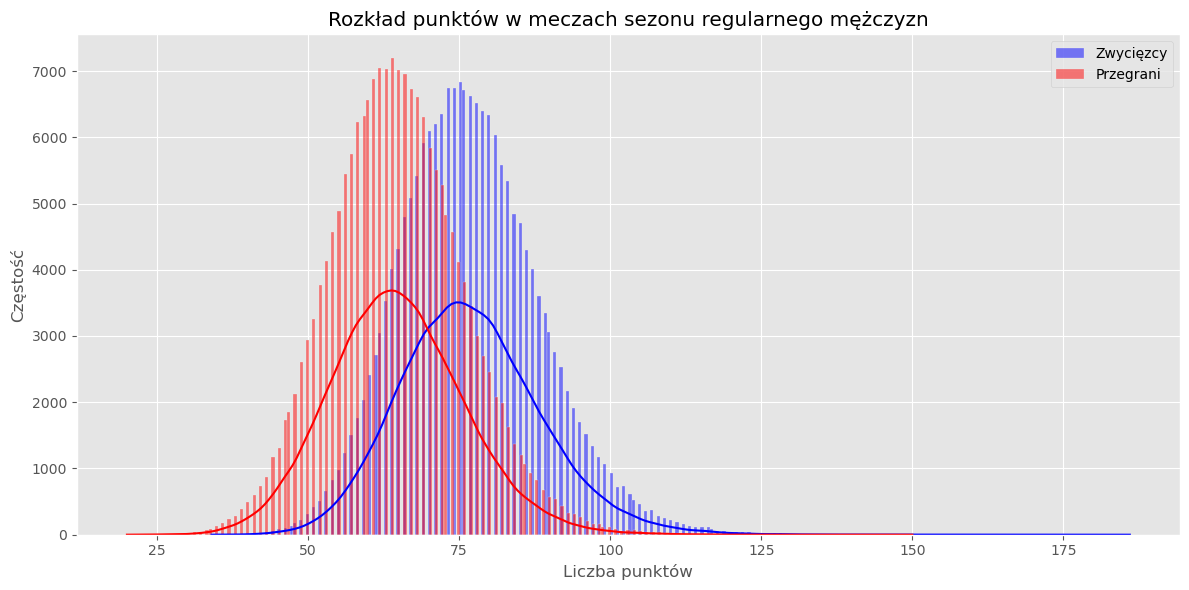


Analiza rozkładu punktów w meczach kobiecych:


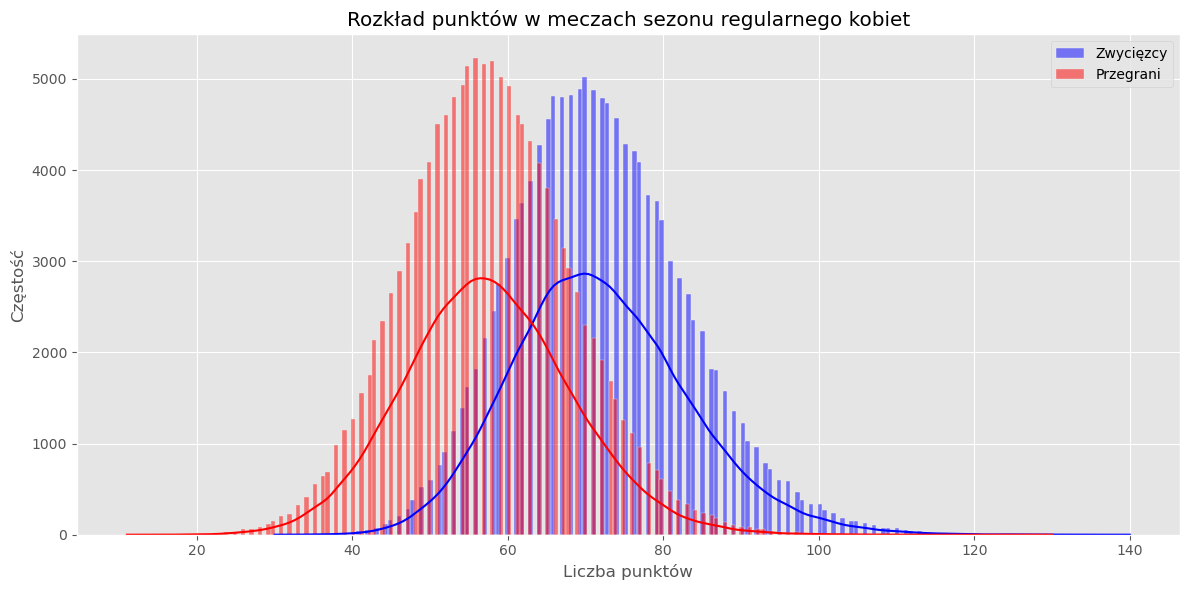

In [97]:
print("\nAnaliza rozkładu punktów w meczach męskich:")
plt.figure(figsize=(12, 6))
sns.histplot(mregular_results_df['WScore'], kde=True, color='blue', label='Zwycięzcy')
sns.histplot(mregular_results_df['LScore'], kde=True, color='red', label='Przegrani')
plt.title('Rozkład punktów w meczach sezonu regularnego mężczyzn')
plt.xlabel('Liczba punktów')
plt.ylabel('Częstość')
plt.legend()
plt.tight_layout()
plt.show()


print("\nAnaliza rozkładu punktów w meczach kobiecych:")
plt.figure(figsize=(12, 6))
sns.histplot(wregular_results_df['WScore'], kde=True, color='blue', label='Zwycięzcy')
sns.histplot(wregular_results_df['LScore'], kde=True, color='red', label='Przegrani')
plt.title('Rozkład punktów w meczach sezonu regularnego kobiet')
plt.xlabel('Liczba punktów')
plt.ylabel('Częstość')
plt.legend()
plt.tight_layout()
plt.show()


Porównanie średnich wyników między mężczyznami i kobietami:
Mężczyźni - średni wynik zwycięzców: 76.86
Mężczyźni - średni wynik przegranych: 64.77
Mężczyźni - średnia różnica punktów: 12.08
Kobiety - średni wynik zwycięzców: 71.92
Kobiety - średni wynik przegranych: 57.52
Kobiety - średnia różnica punktów: 14.41


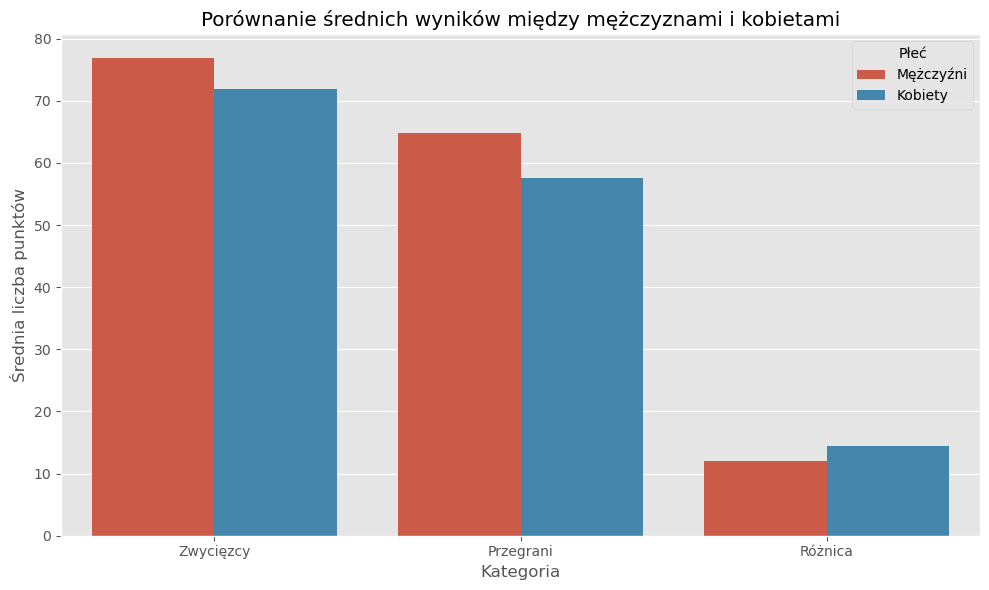

In [98]:
print("\nPorównanie średnich wyników między mężczyznami i kobietami:")
men_avg_w = mregular_results_df['WScore'].mean()
men_avg_l = mregular_results_df['LScore'].mean()
men_diff = men_avg_w - men_avg_l

women_avg_w = wregular_results_df['WScore'].mean()
women_avg_l = wregular_results_df['LScore'].mean()
women_diff = women_avg_w - women_avg_l

print(f"Mężczyźni - średni wynik zwycięzców: {men_avg_w:.2f}")
print(f"Mężczyźni - średni wynik przegranych: {men_avg_l:.2f}")
print(f"Mężczyźni - średnia różnica punktów: {men_diff:.2f}")
print(f"Kobiety - średni wynik zwycięzców: {women_avg_w:.2f}")
print(f"Kobiety - średni wynik przegranych: {women_avg_l:.2f}")
print(f"Kobiety - średnia różnica punktów: {women_diff:.2f}")


# Wykres porównawczy
comparison_data = {
    'Kategoria': ['Zwycięzcy', 'Przegrani', 'Różnica'] * 2,
    'Płeć': ['Mężczyźni'] * 3 + ['Kobiety'] * 3,
    'Średnia': [men_avg_w, men_avg_l, men_diff, women_avg_w, women_avg_l, women_diff]
}
comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Kategoria', y='Średnia', hue='Płeć', data=comparison_df)
plt.title('Porównanie średnich wyników między mężczyznami i kobietami')
plt.ylabel('Średnia liczba punktów')
plt.tight_layout()
plt.show()


Statystyki lokalizacji zwycięzców w meczach męskich:
H    113359
A     58899
N     19538
Name: WLoc, dtype: int64
Procent zwycięstw gospodarzy: 59.10%
Procent zwycięstw gości: 30.71%
Procent zwycięstw na neutralnym boisku: 10.19%


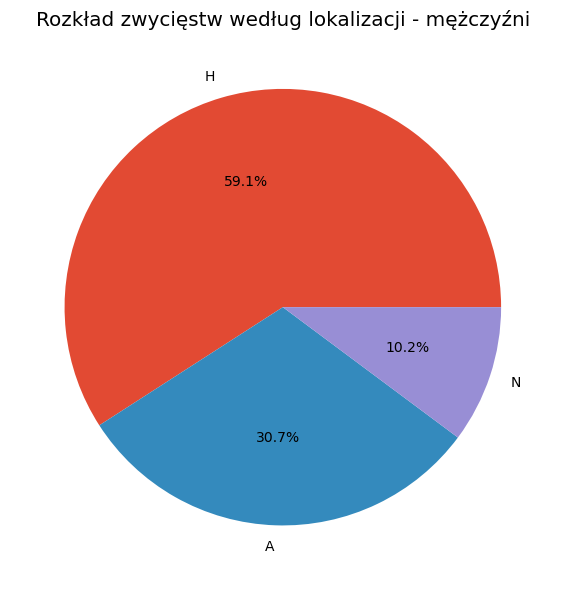

In [99]:
# Analiza przewagi gospodarzy/gości w meczach męskich
print("\nStatystyki lokalizacji zwycięzców w meczach męskich:")
location_stats_m = mregular_results_df['WLoc'].value_counts()
location_percent_m = location_stats_m / len(mregular_results_df) * 100
print(location_stats_m)
print(f"Procent zwycięstw gospodarzy: {location_percent_m.get('H', 0):.2f}%")
print(f"Procent zwycięstw gości: {location_percent_m.get('A', 0):.2f}%")
print(f"Procent zwycięstw na neutralnym boisku: {location_percent_m.get('N', 0):.2f}%")

# Wykres lokalizacji zwycięzców w meczach męskich
plt.figure(figsize=(8, 6))
location_stats_m.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rozkład zwycięstw według lokalizacji - mężczyźni')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Ważne do zanotowania zjawisko - gospodarze częściej wygrywają


Statystyki lokalizacji zwycięzców w meczach kobiecych:
H    77117
A    48874
N     9957
Name: WLoc, dtype: int64
Procent zwycięstw gospodarzy: 56.73%
Procent zwycięstw gości: 35.95%
Procent zwycięstw na neutralnym boisku: 7.32%


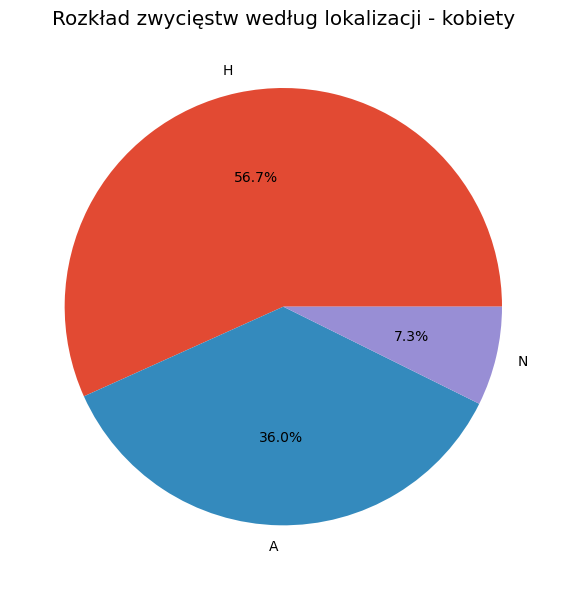

In [100]:
# Analiza przewagi gospodarzy/gości w meczach kobiecych
print("\nStatystyki lokalizacji zwycięzców w meczach kobiecych:")
location_stats_w = wregular_results_df['WLoc'].value_counts()
location_percent_w = location_stats_w / len(wregular_results_df) * 100
print(location_stats_w)
print(f"Procent zwycięstw gospodarzy: {location_percent_w.get('H', 0):.2f}%")
print(f"Procent zwycięstw gości: {location_percent_w.get('A', 0):.2f}%")
print(f"Procent zwycięstw na neutralnym boisku: {location_percent_w.get('N', 0):.2f}%")

# Wykres lokalizacji zwycięzców w meczach kobiecych
plt.figure(figsize=(8, 6))
location_stats_w.plot(kind='pie', autopct='%1.1f%%')
plt.title('Rozkład zwycięstw według lokalizacji - kobiety')
plt.ylabel('')
plt.tight_layout()
plt.show()

#### Podobny rozkład u kobiet


Analiza liczby dogrywek:
Liczba meczów z dogrywkami (mężczyźni):
0    184015
1      6477
2      1057
3       200
4        41
5         5
6         1
Name: NumOT, dtype: int64
Procent meczów z co najmniej jedną dogrywką: 4.06%

Liczba meczów z dogrywkami (kobiety):
0    131340
1      3931
2       573
3        87
4        15
5         2
Name: NumOT, dtype: int64
Procent meczów z co najmniej jedną dogrywką: 3.39%


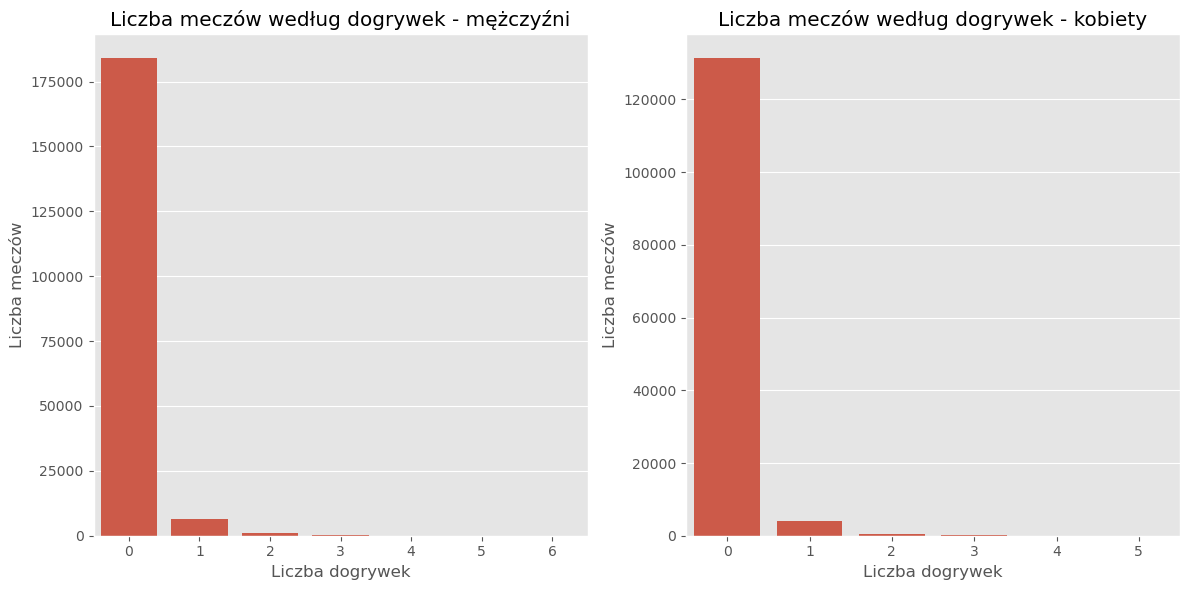

In [102]:
# Analiza liczby dogrywek w meczach
print("\nAnaliza liczby dogrywek:")
ot_counts_m = mregular_results_df['NumOT'].value_counts().sort_index()
ot_counts_w = wregular_results_df['NumOT'].value_counts().sort_index()

print("Liczba meczów z dogrywkami (mężczyźni):")
print(ot_counts_m)
print(f"Procent meczów z co najmniej jedną dogrywką: {(len(mregular_results_df) - ot_counts_m.get(0, 0)) / len(mregular_results_df) * 100:.2f}%")

print("\nLiczba meczów z dogrywkami (kobiety):")
print(ot_counts_w)
print(f"Procent meczów z co najmniej jedną dogrywką: {(len(wregular_results_df) - ot_counts_w.get(0, 0)) / len(wregular_results_df) * 100:.2f}%")

# Wykres dogrywek
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=ot_counts_m.index, y=ot_counts_m.values)
plt.title('Liczba meczów według dogrywek - mężczyźni')
plt.xlabel('Liczba dogrywek')
plt.ylabel('Liczba meczów')

plt.subplot(1, 2, 2)
sns.barplot(x=ot_counts_w.index, y=ot_counts_w.values)
plt.title('Liczba meczów według dogrywek - kobiety')
plt.xlabel('Liczba dogrywek')
plt.ylabel('Liczba meczów')


plt.tight_layout()
plt.show()


Liczba drużyn w turniejach męskich według sezonów:
Season
1985    64
1986    64
1987    64
1988    64
1989    64
1990    64
1991    64
1992    64
1993    64
1994    64
1995    64
1996    64
1997    64
1998    64
1999    64
2000    64
2001    65
2002    65
2003    65
2004    65
2005    65
2006    65
2007    65
2008    65
2009    65
2010    65
2011    68
2012    68
2013    68
2014    68
2015    68
2016    68
2017    68
2018    68
2019    68
2021    68
2022    68
2023    68
2024    68
dtype: int64

Liczba drużyn w turniejach kobiecych według sezonów:
Season
1998    64
1999    64
2000    64
2001    64
2002    64
2003    64
2004    64
2005    64
2006    64
2007    64
2008    64
2009    64
2010    64
2011    64
2012    64
2013    64
2014    64
2015    64
2016    64
2017    64
2018    64
2019    64
2021    64
2022    68
2023    68
2024    68
dtype: int64


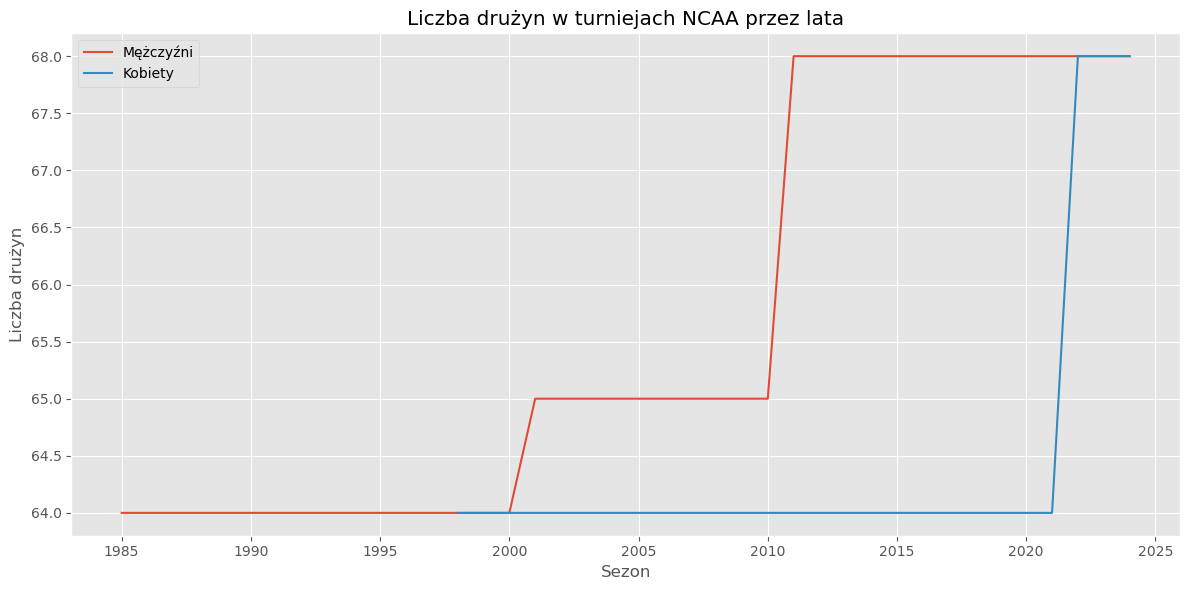

In [103]:
# Liczba drużyn w turniejach przez lata
print("\nLiczba drużyn w turniejach męskich według sezonów:")
teams_per_season_m = mtourney_seeds_df.groupby('Season').size()
print(teams_per_season_m)

print("\nLiczba drużyn w turniejach kobiecych według sezonów:")
teams_per_season_w = wtourney_seeds_df.groupby('Season').size()
print(teams_per_season_w)

# Wykres liczby drużyn w turniejach przez lata
plt.figure(figsize=(12, 6))
teams_per_season_m.plot(label='Mężczyźni')
teams_per_season_w.plot(label='Kobiety')
plt.title('Liczba drużyn w turniejach NCAA przez lata')
plt.xlabel('Sezon')
plt.ylabel('Liczba drużyn')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Analiza różnicy punktów w meczach:
Średnia różnica punktów (mężczyźni): 12.08
Mediana różnicy punktów (mężczyźni): 10.00
Maksymalna różnica punktów (mężczyźni): 94.00
Średnia różnica punktów (kobiety): 14.41
Mediana różnicy punktów (kobiety): 12.00
Maksymalna różnica punktów (kobiety): 108.00


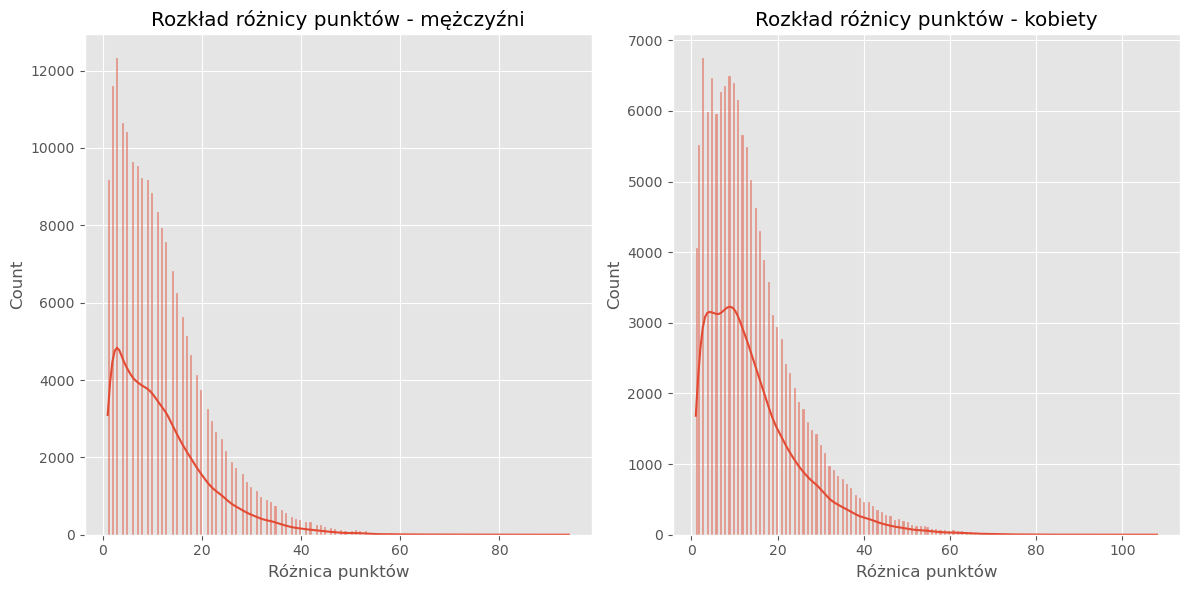

In [109]:
# Analiza różnicy punktów w meczach
print("\nAnaliza różnicy punktów w meczach:")
mregular_results_df['PointDiff'] = mregular_results_df['WScore'] - mregular_results_df['LScore']
wregular_results_df['PointDiff'] = wregular_results_df['WScore'] - wregular_results_df['LScore']

print(f"Średnia różnica punktów (mężczyźni): {mregular_results_df['PointDiff'].mean():.2f}")
print(f"Mediana różnicy punktów (mężczyźni): {mregular_results_df['PointDiff'].median():.2f}")
print(f"Maksymalna różnica punktów (mężczyźni): {mregular_results_df['PointDiff'].max():.2f}")

print(f"Średnia różnica punktów (kobiety): {wregular_results_df['PointDiff'].mean():.2f}")
print(f"Mediana różnicy punktów (kobiety): {wregular_results_df['PointDiff'].median():.2f}")
print(f"Maksymalna różnica punktów (kobiety): {wregular_results_df['PointDiff'].max():.2f}")

# Wykres różnicy punktów
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(mregular_results_df['PointDiff'], kde=True) # gęstość rozkładu
plt.title('Rozkład różnicy punktów - mężczyźni')
plt.xlabel('Różnica punktów')

plt.subplot(1, 2, 2)
sns.histplot(wregular_results_df['PointDiff'], kde=True)
plt.title('Rozkład różnicy punktów - kobiety')
plt.xlabel('Różnica punktów')

plt.tight_layout()
plt.show()


Analiza trendów punktowych przez lata:


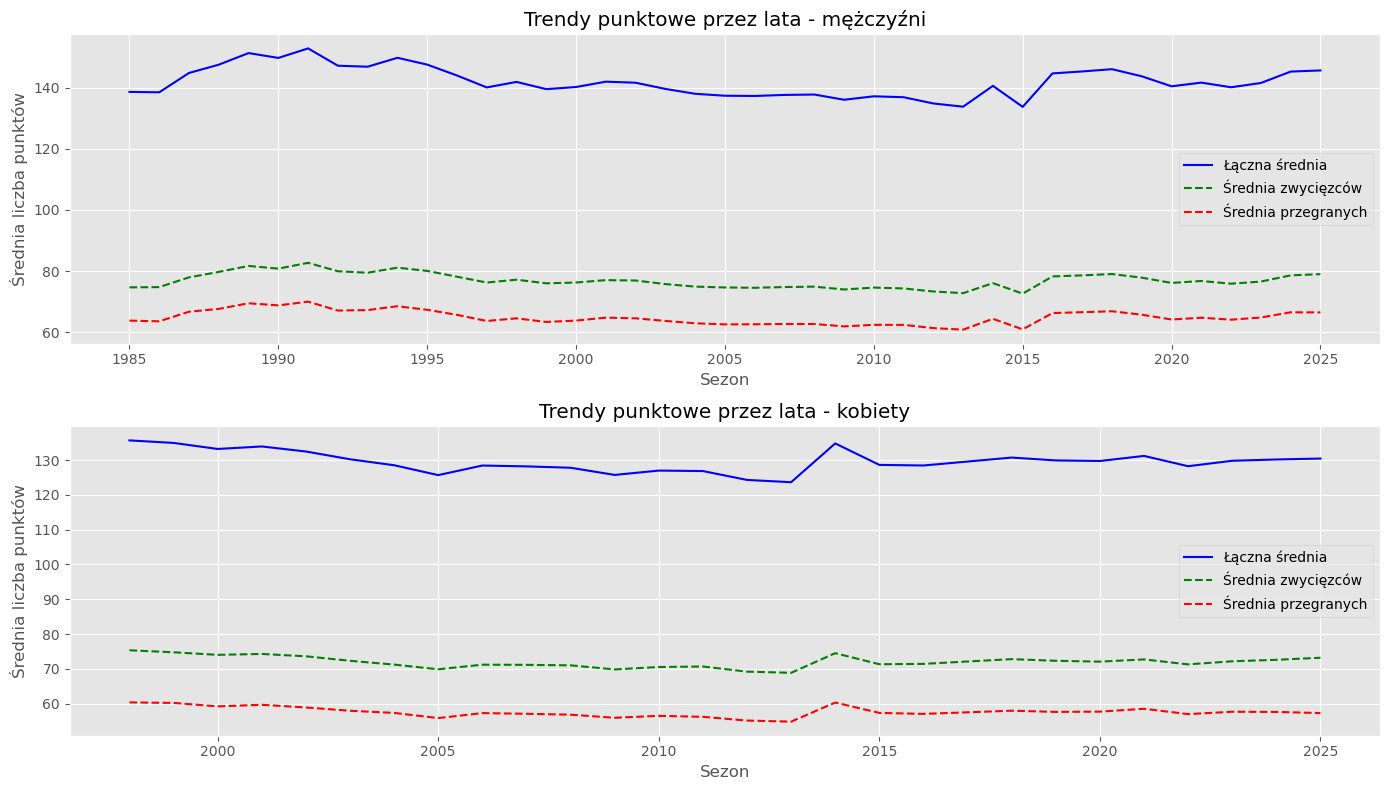

In [110]:
# Analiza trendów punktowych przez lata
print("\nAnaliza trendów punktowych przez lata:")
men_points_by_season = mregular_results_df.groupby('Season').agg({
    'WScore': 'mean',
    'LScore': 'mean'
}).reset_index()
men_points_by_season['AvgTotalPoints'] = men_points_by_season['WScore'] + men_points_by_season['LScore']

women_points_by_season = wregular_results_df.groupby('Season').agg({
    'WScore': 'mean',
    'LScore': 'mean'
}).reset_index()
women_points_by_season['AvgTotalPoints'] = women_points_by_season['WScore'] + women_points_by_season['LScore']

# Wykres trendów punktowych
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(men_points_by_season['Season'], men_points_by_season['AvgTotalPoints'], 'b-', label='Łączna średnia')
plt.plot(men_points_by_season['Season'], men_points_by_season['WScore'], 'g--', label='Średnia zwycięzców')
plt.plot(men_points_by_season['Season'], men_points_by_season['LScore'], 'r--', label='Średnia przegranych')
plt.title('Trendy punktowe przez lata - mężczyźni')
plt.xlabel('Sezon')
plt.ylabel('Średnia liczba punktów')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(women_points_by_season['Season'], women_points_by_season['AvgTotalPoints'], 'b-', label='Łączna średnia')
plt.plot(women_points_by_season['Season'], women_points_by_season['WScore'], 'g--', label='Średnia zwycięzców')
plt.plot(women_points_by_season['Season'], women_points_by_season['LScore'], 'r--', label='Średnia przegranych')
plt.title('Trendy punktowe przez lata - kobiety')
plt.xlabel('Sezon')
plt.ylabel('Średnia liczba punktów')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Linie są prawie równoległe, a to oznacza, że różnica punktów między zwycięzcami a przegranymi pozostaje na względnie stałym poziomie przez lata
Tutaj widać, że choć liczba punktów zmienia się w czasie, to zwycięzcy i przegrani nadal zdobywają punkty w podobnym stosunku do siebie.

Zatem jeśli liga lub turniej utrzymuje podobne style gry, przepisy i poziom drużyn, to różnice między zwycięzcami i przegranymi mogą pozostawać podobne.

Można zatem się spodziewać, że różnice punktowe nie zmieniają się drastycznie w długim czasie


Analiza wpływu rozstawienia na wyniki turniejowe:

Liczba zwycięstw według rozstawienia (mężczyźni):
1     515
2     363
3     287
4     243
5     180
6     163
7     139
8     111
9      96
10     96
11    122
12     83
13     40
14     26
15     16
16     38
Name: WSeedNumber, dtype: int64

Liczba zwycięstw według rozstawienia (kobiety):
1     400
2     278
3     222
4     181
5     128
6     100
7      92
8      56
9      57
10     42
11     53
12     26
13      8
16      7
Name: WSeedNumber, dtype: int64


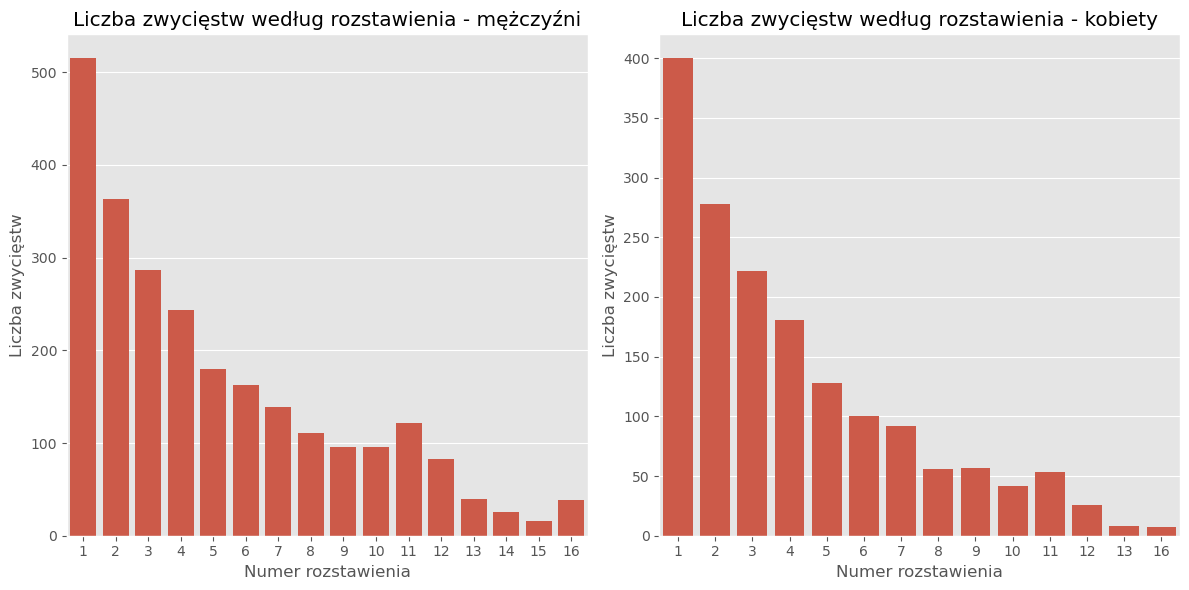

In [113]:
# Analiza wpływu rozstawienia na wyniki turniejowe
print("\nAnaliza wpływu rozstawienia na wyniki turniejowe:")

# Przetwarzanie danych turniejowych - dodanie informacji o rozstawieniu
def extract_seed_number(seed_str):
    """Wyodrębnia numer rozstawienia z ciągu znaków"""
    # Usuń region (W, X, Y, Z) i ewentualny dodatkowy znak (a, b)
    if len(seed_str) > 2:
        return int(seed_str[1:3])
    return None

# Łączenie danych o rozstawieniach z wynikami turniejów
mtourney_seeds_df['SeedNumber'] = mtourney_seeds_df['Seed'].apply(extract_seed_number)
wtourney_seeds_df['SeedNumber'] = wtourney_seeds_df['Seed'].apply(extract_seed_number)

# Tworzenie słowników dla łatwego dostępu do rozstawień
def create_seed_dict(seeds_df):
    seed_dict = {}
    for _, row in seeds_df.iterrows():
        seed_dict[(row['Season'], row['TeamID'])] = row['SeedNumber']
    return seed_dict

mseed_dict = create_seed_dict(mtourney_seeds_df)
wseed_dict = create_seed_dict(wtourney_seeds_df)

# Dodawanie informacji o rozstawieniu do wyników turniejów
mtourney_results_df['WSeedNumber'] = mtourney_results_df.apply(
    lambda row: mseed_dict.get((row['Season'], row['WTeamID']), None), axis=1)
mtourney_results_df['LSeedNumber'] = mtourney_results_df.apply(
    lambda row: mseed_dict.get((row['Season'], row['LTeamID']), None), axis=1)

wtourney_results_df['WSeedNumber'] = wtourney_results_df.apply(
    lambda row: wseed_dict.get((row['Season'], row['WTeamID']), None), axis=1)
wtourney_results_df['LSeedNumber'] = wtourney_results_df.apply(
    lambda row: wseed_dict.get((row['Season'], row['LTeamID']), None), axis=1)

# Analiza liczby zwycięstw według rozstawienia
print("\nLiczba zwycięstw według rozstawienia (mężczyźni):")
mseed_wins = mtourney_results_df['WSeedNumber'].value_counts().sort_index()
print(mseed_wins)

print("\nLiczba zwycięstw według rozstawienia (kobiety):")
wseed_wins = wtourney_results_df['WSeedNumber'].value_counts().sort_index()
print(wseed_wins)

# Wykres liczby zwycięstw według rozstawienia
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=mseed_wins.index, y=mseed_wins.values)
plt.title('Liczba zwycięstw według rozstawienia - mężczyźni')
plt.xlabel('Numer rozstawienia')
plt.ylabel('Liczba zwycięstw')

plt.subplot(1, 2, 2)
sns.barplot(x=wseed_wins.index, y=wseed_wins.values)
plt.title('Liczba zwycięstw według rozstawienia - kobiety')
plt.xlabel('Numer rozstawienia')
plt.ylabel('Liczba zwycięstw')

plt.tight_layout()
plt.show()

In [151]:
# Funkcja do wczytywania danych
def load_data(file_path):
    """Wczytuje dane z pliku CSV."""
    return pd.read_csv(file_path)

# Funkcja do łączenia danych z różnych plików (sezon regularny i turniej NCAA)
def combine_data(regular_season_file, tournament_file):
    """Łączy dane z sezonu regularnego i turnieju."""
    regular_season_data = load_data(regular_season_file)
    regular_season_data['DataType'] = 'Regular Season'  # tworzy nową kolumnę
    
    tournament_data = load_data(tournament_file)
    tournament_data['DataType'] = 'NCAA Tournament'
    
    return pd.concat([regular_season_data, tournament_data], ignore_index=True)

# Funkcja do analizy podstawowych statystyk
def basic_stats_analysis(data):
    """Analiza podstawowych statystyk w danych."""
    # Obliczenie średnich statystyk dla drużyn wygrywających i przegrywających
    winning_stats = data[[col for col in data.columns if col.startswith('W') and col not in ['WTeamID', 'WScore', 'WLoc']]].mean()
    losing_stats = data[[col for col in data.columns if col.startswith('L') and col not in ['LTeamID', 'LScore']]].mean()
    
    # Przekształcenie do formatu DataFrame dla łatwiejszej analizy
    stats_comparison = pd.DataFrame({
        'Winning_Team': winning_stats,
        'Losing_Team': losing_stats
    })
    
    # Dodanie kolumny z różnicą
    stats_comparison['Difference'] = stats_comparison['Winning_Team'] - stats_comparison['Losing_Team']
    stats_comparison['Pct_Difference'] = (stats_comparison['Difference'] / stats_comparison['Losing_Team'] * 100).round(2)
    
    return stats_comparison

# Funkcja do analizy efektywności
def efficiency_analysis(data):
    """Analiza efektywności drużyn."""
    # Obliczenie skuteczności rzutów dla drużyn wygrywających
    data['WFG_Pct'] = (data['WFGM'] / data['WFGA'] * 100).round(2)
    data['W3P_Pct'] = (data['WFGM3'] / data['WFGA3'] * 100).round(2)
    data['WFT_Pct'] = (data['WFTM'] / data['WFTA'] * 100).round(2)
    
    # Obliczenie skuteczności rzutów dla drużyn przegrywających
    data['LFG_Pct'] = (data['LFGM'] / data['LFGA'] * 100).round(2)
    data['L3P_Pct'] = (data['LFGM3'] / data['LFGA3'] * 100).round(2)
    data['LFT_Pct'] = (data['LFTM'] / data['LFTA'] * 100).round(2)
    
    # Obliczenie dodatkowych statystyk efektywności
    data['WPossessions'] = data['WFGA'] + data['WTO'] * 0.96 + data['WFTA'] * 0.44 - data['WOR']
    data['LPossessions'] = data['LFGA'] + data['LTO'] * 0.96 + data['LFTA'] * 0.44 - data['LOR']
    
    data['WOffEff'] = (data['WScore'] / data['WPossessions'] * 100).round(2)
    data['LOffEff'] = (data['LScore'] / data['LPossessions'] * 100).round(2)
    
    # Obliczenie różnicy w posiadaniu piłki
    data['Pace'] = ((data['WPossessions'] + data['LPossessions']) / 2).round(2)
    
    # Analiza efektywności rzutów
    efficiency_stats = pd.DataFrame({
        'Winning_FG_Pct': data['WFG_Pct'].mean(),
        'Losing_FG_Pct': data['LFG_Pct'].mean(),
        'Winning_3P_Pct': data['W3P_Pct'].mean(),
        'Losing_3P_Pct': data['L3P_Pct'].mean(),
        'Winning_FT_Pct': data['WFT_Pct'].mean(),
        'Losing_FT_Pct': data['LFT_Pct'].mean(),
        'Winning_OffEff': data['WOffEff'].mean(),
        'Losing_OffEff': data['LOffEff'].mean(),
        'Avg_Pace': data['Pace'].mean()
    }, index=[0])
    
    return data, efficiency_stats

# Funkcja do analizy trendów czasowych
def time_trend_analysis(data):
    """Analiza trendów czasowych w statystykach."""
    # Grupowanie danych według sezonu
    yearly_stats = data.groupby('Season').agg({
        'WScore': 'mean',
        'LScore': 'mean',
        'WFGA3': 'mean',
        'LFGA3': 'mean',
        'WFG_Pct': 'mean',
        'LFG_Pct': 'mean',
        'W3P_Pct': 'mean',
        'L3P_Pct': 'mean',
        'WOffEff': 'mean',
        'LOffEff': 'mean',
        'Pace': 'mean'
    })
    
    # Dodanie kolumn z całkowitą liczbą punktów i różnicą punktów
    yearly_stats['Total_Points'] = yearly_stats['WScore'] + yearly_stats['LScore']
    yearly_stats['Point_Diff'] = yearly_stats['WScore'] - yearly_stats['LScore']
    yearly_stats['Total_3PA'] = yearly_stats['WFGA3'] + yearly_stats['LFGA3']
    
    return yearly_stats

# Funkcja do analizy korelacji
def correlation_analysis(data):
    """Analiza korelacji między różnymi statystykami."""
    # Wybór kolumn do analizy korelacji
    corr_columns = [
        'WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
        'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
        'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
        'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
        'WFG_Pct', 'W3P_Pct', 'WFT_Pct', 'LFG_Pct', 'L3P_Pct', 'LFT_Pct',
        'WOffEff', 'LOffEff', 'Pace'
    ]
    
    # Obliczenie macierzy korelacji
    correlation_matrix = data[corr_columns].corr()
    
    return correlation_matrix





# Safe division function to handle division by zero
def safe_div(x, y):
    return np.where(y != 0, x / y * 100, 0)  # Return 0% when no attempts





# Funkcja do porównania koszykówki męskiej i żeńskiej
def compare_mens_womens(men_data, women_data):
    """Porównanie statystyk między koszykówką męską i żeńską."""
    # Słownik z podstawowymi statystykami do porównania
    comparison_stats = {
        'avg_score': ('WScore', 'LScore'),
        'fg_pct': ('WFG_Pct', 'LFG_Pct'),
        '3p_pct': ('W3P_Pct', 'L3P_Pct'),
        'ft_pct': ('WFT_Pct', 'LFT_Pct'),
        'rebounds': ('WOR', 'WDR', 'LOR', 'LDR'),
        'assists': ('WAst', 'LAst'),
        'steals': ('WStl', 'LStl'),
        'blocks': ('WBlk', 'LBlk'),
        'turnovers': ('WTO', 'LTO'),
        'fouls': ('WPF', 'LPF'),
        'efficiency': ('WOffEff', 'LOffEff'),
        'pace': ('Pace',)
    }
    
    # Ograniczenie danych mężczyzn do tego samego okresu co dane kobiet
    men_subset = men_data[men_data['Season'] >= women_data['Season'].min()]
    
    # Przygotowanie DataFrame do porównania
    comparison_results = {}
    
    for stat_name, stat_columns in comparison_stats.items():
        men_values = []
        women_values = []
        
        for col in stat_columns:
            if col in men_subset.columns and col in women_data.columns:
                men_values.append(men_subset[col].mean())
                women_values.append(women_data[col].mean())
        
        if men_values and women_values:  # Jeśli obie listy nie są puste
            comparison_results[stat_name] = {
                'Men': np.mean(men_values),
                'Women': np.mean(women_values),
                'Difference': np.mean(men_values) - np.mean(women_values),
                'Pct_Difference': ((np.mean(men_values) - np.mean(women_values)) / np.mean(women_values) * 100).round(2)
            }
    
    return pd.DataFrame(comparison_results).T

# Funkcja do wizualizacji podstawowych statystyk
def visualize_basic_stats(stats_comparison):
    """Wizualizacja podstawowych statystyk."""
    # Wybór najważniejszych statystyk do wizualizacji
    important_stats = ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
    
    # Przygotowanie danych do wizualizacji
    plot_data = pd.DataFrame()
    
    for stat in important_stats:
        if f'W{stat}' in stats_comparison.index and f'L{stat}' in stats_comparison.index:
            plot_data[stat] = [
                stats_comparison.loc[f'W{stat}', 'Winning_Team'],
                stats_comparison.loc[f'L{stat}', 'Losing_Team']
            ]
    
    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(14, 10))
    
    x = np.arange(len(important_stats))
    width = 0.35
    
    ax.bar(x - width/2, plot_data.iloc[0], width, label='Winning Teams')
    ax.bar(x + width/2, plot_data.iloc[1], width, label='Losing Teams')
    
    ax.set_xticks(x)
    ax.set_xticklabels(important_stats)
    ax.set_ylabel('Average Value')
    ax.set_title('Comparison of Key Statistics Between Winning and Losing Teams')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('basic_stats_comparison.png')
    plt.show()
    plt.close()

# Funkcja do wizualizacji efektywności
def visualize_efficiency(efficiency_stats):
    """Wizualizacja statystyk efektywności."""
    # Przygotowanie danych do wizualizacji
    categories = ['FG_Pct', '3P_Pct', 'FT_Pct']
    winning_values = [efficiency_stats['Winning_FG_Pct'][0], efficiency_stats['Winning_3P_Pct'][0], efficiency_stats['Winning_FT_Pct'][0]]
    losing_values = [efficiency_stats['Losing_FG_Pct'][0], efficiency_stats['Losing_3P_Pct'][0], efficiency_stats['Losing_FT_Pct'][0]]
    
    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax.bar(x - width/2, winning_values, width, label='Winning Teams')
    ax.bar(x + width/2, losing_values, width, label='Losing Teams')
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Shooting Efficiency Comparison')
    ax.legend()
    
    # Dodanie wartości na wykresie
    for i, v in enumerate(winning_values):
        ax.text(i - width/2, v + 0.5, f"{v:.1f}%", ha='center')
    
    for i, v in enumerate(losing_values):
        ax.text(i + width/2, v + 0.5, f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.savefig('shooting_efficiency_comparison.png')
    plt.show()
    plt.close()
    
    # Wykres efektywności ofensywnej
    fig, ax = plt.subplots(figsize=(8, 6))
    
    categories = ['Offensive Efficiency']
    winning_values = [efficiency_stats['Winning_OffEff'][0]]
    losing_values = [efficiency_stats['Losing_OffEff'][0]]
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax.bar(x - width/2, winning_values, width, label='Winning Teams')
    ax.bar(x + width/2, losing_values, width, label='Losing Teams')
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Points per 100 Possessions')
    ax.set_title('Offensive Efficiency Comparison')
    ax.legend()
    
    # Dodanie wartości na wykresie
    for i, v in enumerate(winning_values):
        ax.text(i - width/2, v + 0.5, f"{v:.1f}", ha='center')
    
    for i, v in enumerate(losing_values):
        ax.text(i + width/2, v + 0.5, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.savefig('offensive_efficiency_comparison.png')
    plt.show()
    plt.close()

# Funkcja do wizualizacji trendów czasowych
def visualize_time_trends(yearly_stats):
    """Wizualizacja trendów czasowych w statystykach."""
    # Tworzenie wykresu trendów punktowych
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(yearly_stats.index, yearly_stats['WScore'], marker='o', label='Winning Team Score')
    ax.plot(yearly_stats.index, yearly_stats['LScore'], marker='s', label='Losing Team Score')
    ax.plot(yearly_stats.index, yearly_stats['Total_Points'], marker='^', label='Total Points')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Points')
    ax.set_title('Scoring Trends Over Time')
    ax.legend()
    
    # Dodanie siatki
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('scoring_trends.png')
    plt.show()
    plt.close()
    
    # Tworzenie wykresu trendów trzypunktowych
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(yearly_stats.index, yearly_stats['WFGA3'], marker='o', label='Winning Team 3PA')
    ax.plot(yearly_stats.index, yearly_stats['LFGA3'], marker='s', label='Losing Team 3PA')
    ax.plot(yearly_stats.index, yearly_stats['Total_3PA'], marker='^', label='Total 3PA')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('3-Point Attempts')
    ax.set_title('3-Point Shooting Trends Over Time')
    ax.legend()
    
    # Dodanie siatki
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('three_point_trends.png')
    plt.show()
    plt.close()
    
    # Tworzenie wykresu trendów skuteczności
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(yearly_stats.index, yearly_stats['WFG_Pct'], marker='o', label='Winning Team FG%')
    ax.plot(yearly_stats.index, yearly_stats['LFG_Pct'], marker='s', label='Losing Team FG%')
    ax.plot(yearly_stats.index, yearly_stats['W3P_Pct'], marker='^', label='Winning Team 3P%')
    ax.plot(yearly_stats.index, yearly_stats['L3P_Pct'], marker='v', label='Losing Team 3P%')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Shooting Efficiency Trends Over Time')
    ax.legend()
    
    # Dodanie siatki
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('efficiency_trends.png')
    plt.show()
    plt.close()
    
    # Tworzenie wykresu trendów tempa gry
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(yearly_stats.index, yearly_stats['Pace'], marker='o', label='Pace (Possessions per Game)')
    ax.plot(yearly_stats.index, yearly_stats['WOffEff'], marker='s', label='Winning Team Off. Efficiency')
    ax.plot(yearly_stats.index, yearly_stats['LOffEff'], marker='^', label='Losing Team Off. Efficiency')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Value')
    ax.set_title('Pace and Efficiency Trends Over Time')
    ax.legend()
    
    # Dodanie siatki
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('pace_trends.png')
    plt.show()
    plt.close()

# Funkcja do wizualizacji macierzy korelacji
def visualize_correlation(correlation_matrix):
    """Wizualizacja macierzy korelacji między statystykami."""
    # Wybór najważniejszych statystyk do wizualizacji
    important_stats = [
        'WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WOR', 'WDR',
        'WAst', 'WTO', 'WStl', 'WBlk', 'WFG_Pct', 'W3P_Pct', 'WOffEff'
    ]
    
    # Filtrowanie macierzy korelacji
    filtered_corr = correlation_matrix.loc[important_stats, important_stats]
    
    # Tworzenie heatmapy
    plt.figure(figsize=(14, 12))
    sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Key Statistics')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
    plt.close()

# Funkcja do wizualizacji ważności cech w modelu predykcyjnym
def visualize_feature_importance(feature_importance):
    """Wizualizacja ważności cech w modelu predykcyjnym."""
    # Tworzenie wykresu
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Most Important Features for Predicting Game Outcomes')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    plt.close()

# Funkcja do wizualizacji porównania koszykówki męskiej i żeńskiej
def visualize_gender_comparison(comparison_df):
    """Wizualizacja porównania koszykówki męskiej i żeńskiej."""
    # Wybór najważniejszych statystyk do wizualizacji
    important_stats = ['avg_score', 'fg_pct', '3p_pct', 'ft_pct', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'pace']
    
    # Filtrowanie danych
    plot_data = comparison_df.loc[important_stats]
    
    # Tworzenie wykresu
    fig, ax = plt.subplots(figsize=(14, 10))
    
    x = np.arange(len(important_stats))
    width = 0.35
    
    ax.bar(x - width/2, plot_data['Men'], width, label='Men')
    ax.bar(x + width/2, plot_data['Women'], width, label='Women')
    
    ax.set_xticks(x)
    ax.set_xticklabels(important_stats)
    ax.set_ylabel('Value')
    ax.set_title('Comparison of Key Statistics Between Men\'s and Women\'s Basketball')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('gender_comparison.png')
    plt.show()
    plt.close()

In [152]:
def predictive_model(data):
    """Budowa modelu predykcyjnego do przewidywania zwycięzcy."""
    # Przygotowanie danych - utworzenie nowego DataFrame z perspektywy obu drużyn
    model_data = []
    
    for _, row in data.iterrows():
        # Statystyki pierwszej drużyny (oznaczonej jako Team1)
        team1_stats = {
            'Season': row['Season'],
            'Team1ID': row['WTeamID'],
            'Team2ID': row['LTeamID'],
            'Team1Score': row['WScore'],
            'Team2Score': row['LScore'],
            'ScoreDiff': row['WScore'] - row['LScore'],
            'Team1FGM': row['WFGM'],
            'Team1FGA': row['WFGA'],
            'Team1FGM3': row['WFGM3'],
            'Team1FGA3': row['WFGA3'],
            'Team1FTM': row['WFTM'],
            'Team1FTA': row['WFTA'],
            'Team1OR': row['WOR'],
            'Team1DR': row['WDR'],
            'Team1Ast': row['WAst'],
            'Team1TO': row['WTO'],
            'Team1Stl': row['WStl'],
            'Team1Blk': row['WBlk'],
            'Team1PF': row['WPF'],
            'Team2FGM': row['LFGM'],
            'Team2FGA': row['LFGA'],
            'Team2FGM3': row['LFGM3'],
            'Team2FGA3': row['LFGA3'],
            'Team2FTM': row['LFTM'],
            'Team2FTA': row['LFTA'],
            'Team2OR': row['LOR'],
            'Team2DR': row['LDR'],
            'Team2Ast': row['LAst'],
            'Team2TO': row['LTO'],
            'Team2Stl': row['LStl'],
            'Team2Blk': row['LBlk'],
            'Team2PF': row['LPF'],
            'Result': 1  # Team1 wygrywa
        }
        model_data.append(team1_stats)
        
        # Statystyki drugiej drużyny (oznaczonej jako Team2) - zamiana statystyk
        team2_stats = {
            'Season': row['Season'],
            'Team1ID': row['LTeamID'],
            'Team2ID': row['WTeamID'],
            'Team1Score': row['LScore'],
            'Team2Score': row['WScore'],
            'ScoreDiff': row['LScore'] - row['WScore'],
            'Team1FGM': row['LFGM'],
            'Team1FGA': row['LFGA'],
            'Team1FGM3': row['LFGM3'],
            'Team1FGA3': row['LFGA3'],
            'Team1FTM': row['LFTM'],
            'Team1FTA': row['LFTA'],
            'Team1OR': row['LOR'],
            'Team1DR': row['LDR'],
            'Team1Ast': row['LAst'],
            'Team1TO': row['LTO'],
            'Team1Stl': row['LStl'],
            'Team1Blk': row['LBlk'],
            'Team1PF': row['LPF'],
            'Team2FGM': row['WFGM'],
            'Team2FGA': row['WFGA'],
            'Team2FGM3': row['WFGM3'],
            'Team2FGA3': row['WFGA3'],
            'Team2FTM': row['WFTM'],
            'Team2FTA': row['WFTA'],
            'Team2OR': row['WOR'],
            'Team2DR': row['WDR'],
            'Team2Ast': row['WAst'],
            'Team2TO': row['WTO'],
            'Team2Stl': row['WStl'],
            'Team2Blk': row['WBlk'],
            'Team2PF': row['WPF'],
            'Result': 0  # Team2 przegrywa
        }
        model_data.append(team2_stats)
    
    model_df = pd.DataFrame(model_data)
    
    # Safe division function to handle division by zero
    def safe_div(x, y):
        return np.where(y != 0, x / y * 100, 0)  # Return 0% when no attempts
    
    # Dodanie kolumn z efektywnością używając bezpiecznej funkcji dzielenia
    model_df['Team1FG_Pct'] = safe_div(model_df['Team1FGM'], model_df['Team1FGA']).round(2)
    model_df['Team13P_Pct'] = safe_div(model_df['Team1FGM3'], model_df['Team1FGA3']).round(2)
    model_df['Team1FT_Pct'] = safe_div(model_df['Team1FTM'], model_df['Team1FTA']).round(2)
    
    model_df['Team2FG_Pct'] = safe_div(model_df['Team2FGM'], model_df['Team2FGA']).round(2)
    model_df['Team23P_Pct'] = safe_div(model_df['Team2FGM3'], model_df['Team2FGA3']).round(2)
    model_df['Team2FT_Pct'] = safe_div(model_df['Team2FTM'], model_df['Team2FTA']).round(2)
    
    # Wybór cech do modelu
    features = [
        'Team1FG_Pct', 'Team13P_Pct', 'Team1FT_Pct', 'Team1OR', 'Team1DR',
        'Team1Ast', 'Team1TO', 'Team1Stl', 'Team1Blk', 'Team1PF',
        'Team2FG_Pct', 'Team23P_Pct', 'Team2FT_Pct', 'Team2OR', 'Team2DR',
        'Team2Ast', 'Team2TO', 'Team2Stl', 'Team2Blk', 'Team2PF'
    ]
    
    X = model_df[features]
    y = model_df['Result']
    
    # Podział danych na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Normalizacja danych
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Trenowanie modelu
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Predykcja na zbiorze testowym
    y_pred_proba = rf_model.predict_proba(X_test_scaled)
    y_pred = rf_model.predict(X_test_scaled)
    
    # Ocena modelu
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    brier = brier_score_loss(y_test, y_pred_proba[:, 1])
    
    # Ważność cech
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    return accuracy, report, brier, feature_importance, rf_model, scaler, features



Loading and combining men's basketball data...
Loading and combining women's basketball data...
Analyzing basic statistics...

Men's Basic Statistics Comparison:
       Winning_Team  Losing_Team  Difference  Pct_Difference
LAst            NaN        11.41         NaN             NaN
LBlk            NaN         2.87         NaN             NaN
LDR             NaN        21.62         NaN             NaN
LFGA            NaN        56.80         NaN             NaN
LFGA3           NaN        20.17         NaN             NaN
LFGM            NaN        22.80         NaN             NaN
LFGM3           NaN         6.21         NaN             NaN
LFTA            NaN        17.72         NaN             NaN
LFTM            NaN        12.07         NaN             NaN
LOR             NaN        10.46         NaN             NaN
LPF             NaN        19.30         NaN             NaN
LStl            NaN         6.00         NaN             NaN
LTO             NaN        13.87         NaN 

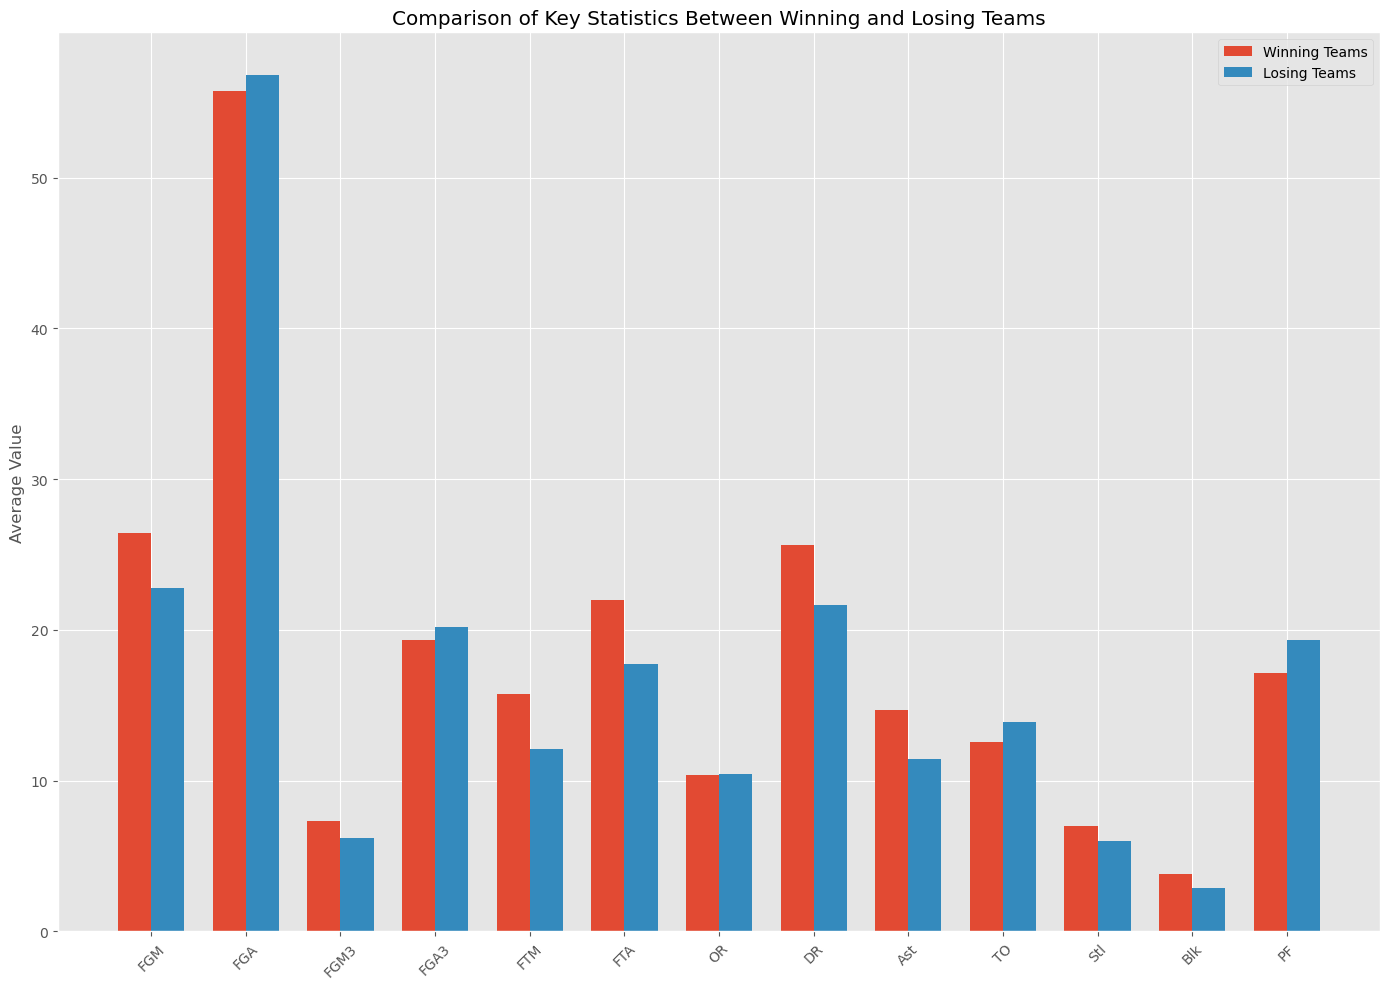

Analyzing efficiency...

Men's Efficiency Statistics:
   Winning_FG_Pct  Losing_FG_Pct  Winning_3P_Pct  Losing_3P_Pct  \
0           47.49          40.27           37.89          30.61   

   Winning_FT_Pct  Losing_FT_Pct  Winning_OffEff  Losing_OffEff  Avg_Pace  
0           71.47          67.92          113.06          94.71     67.29  
Visualizing efficiency...


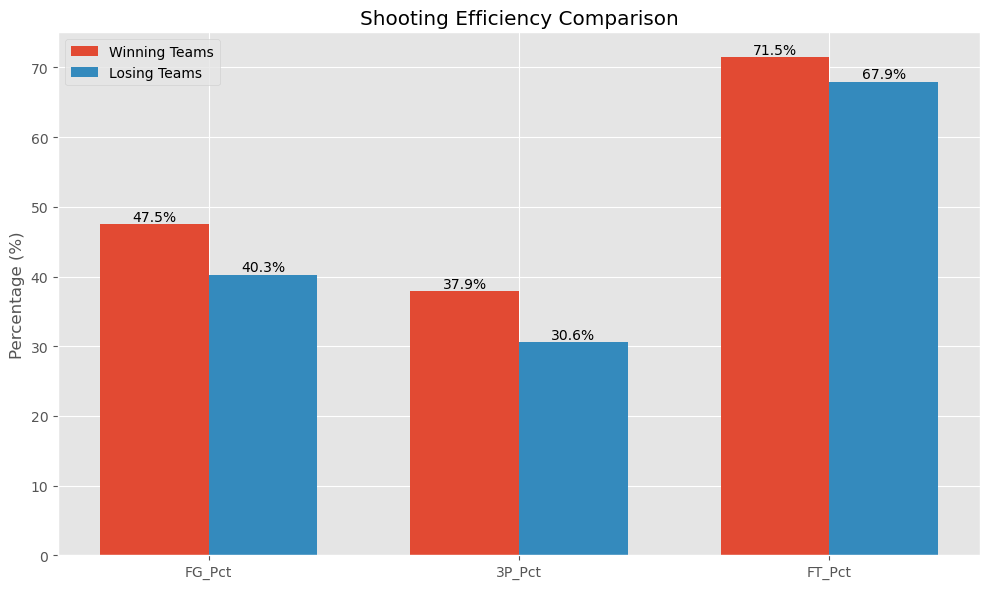

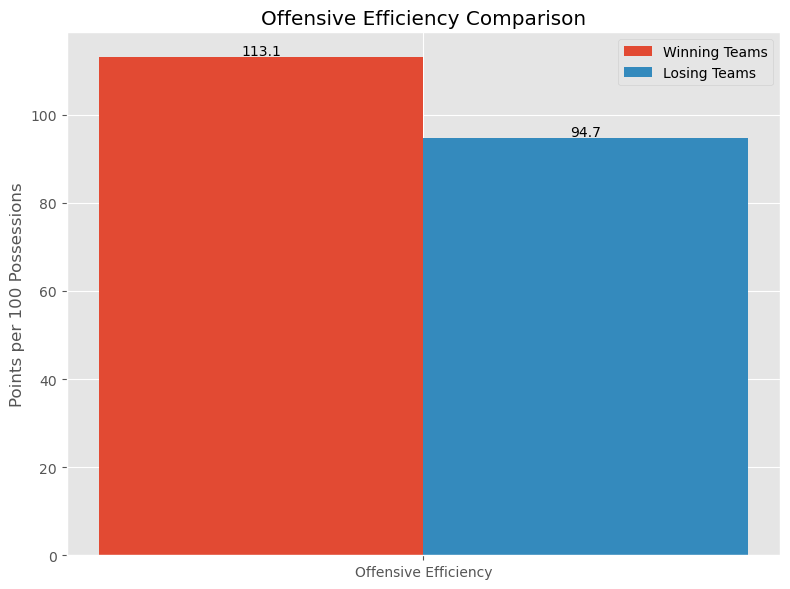

Analyzing time trends...

Men's Yearly Statistics:
        WScore  LScore  WFGA3  LFGA3  WFG_Pct  LFG_Pct  W3P_Pct  L3P_Pct  \
Season                                                                     
2003     75.81   63.78  17.36  18.74    47.67    40.36    38.47    31.00   
2004     74.98   63.01  17.57  18.85    47.26    40.24    38.16    30.81   
2005     74.71   62.67  17.68  18.93    47.47    40.19    38.16    30.94   
2006     74.57   62.67  17.82  18.90    47.38    40.35    38.23    31.23   
2007     74.84   62.77  18.14  19.46    47.92    40.38    38.69    30.93   

        WOffEff  LOffEff  Pace  Total_Points  Point_Diff  Total_3PA  
Season                                                               
2003     112.07    93.99 67.76        139.59       12.02      36.10  
2004     111.66    93.49 67.30        137.99       11.97      36.42  
2005     111.96    93.60 66.88        137.38       12.03      36.62  
2006     112.24    93.97 66.59        137.24       11.90      36.7

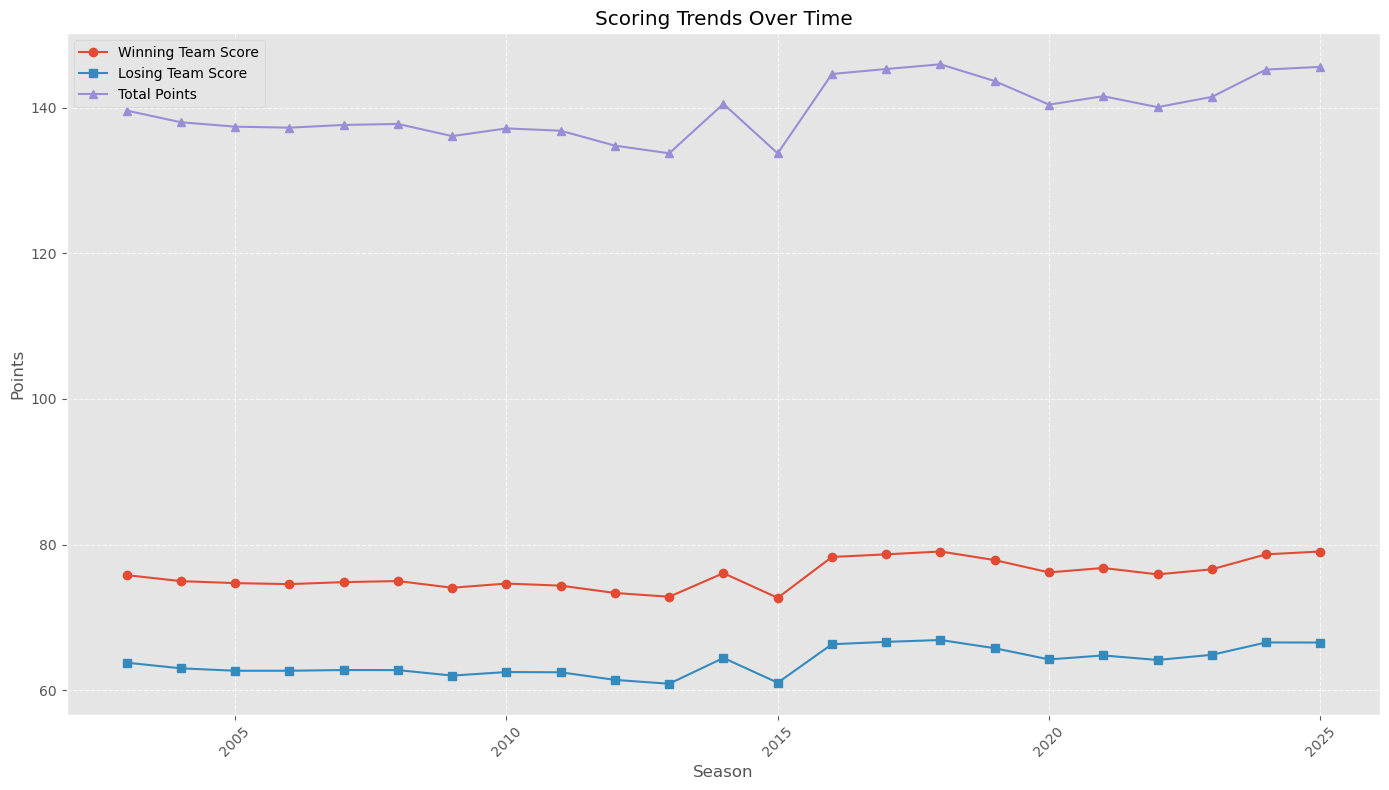

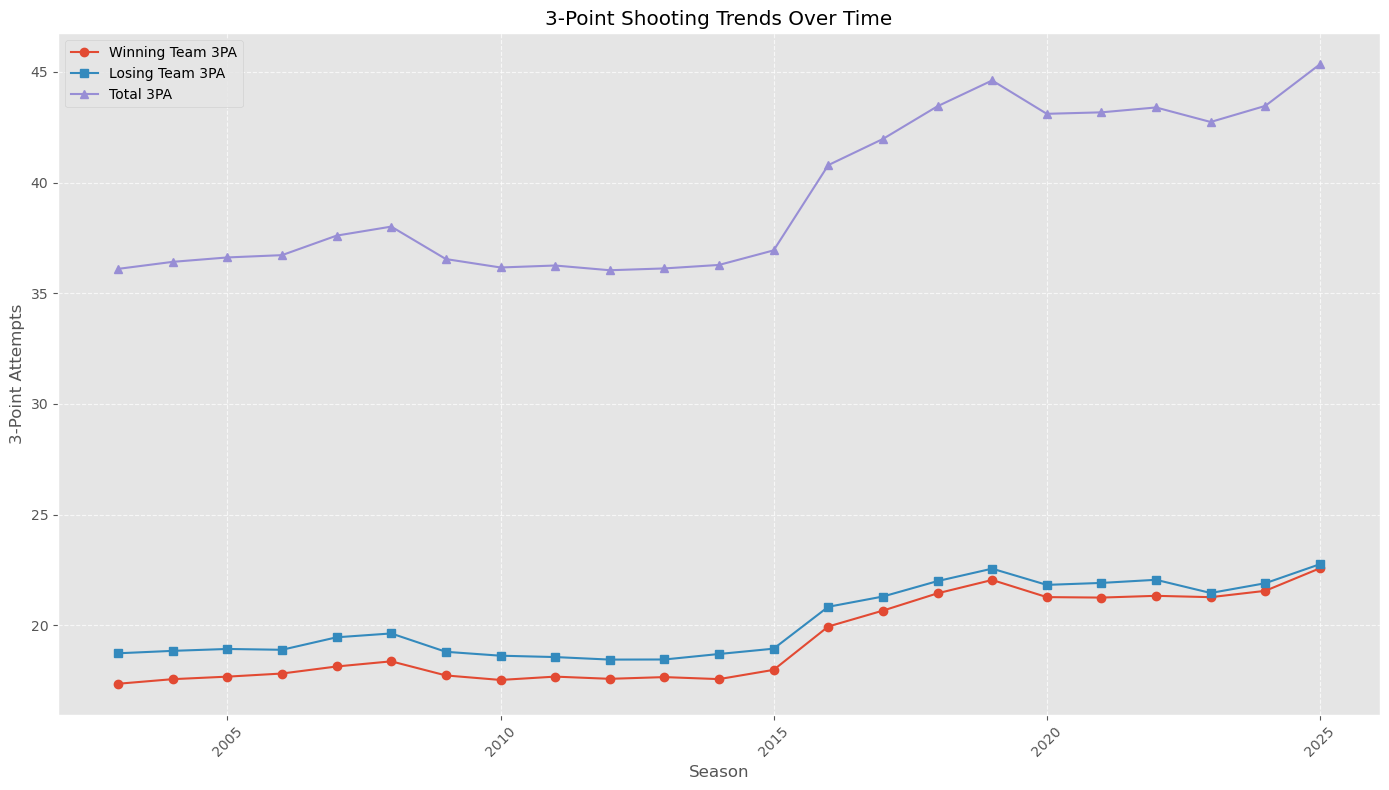

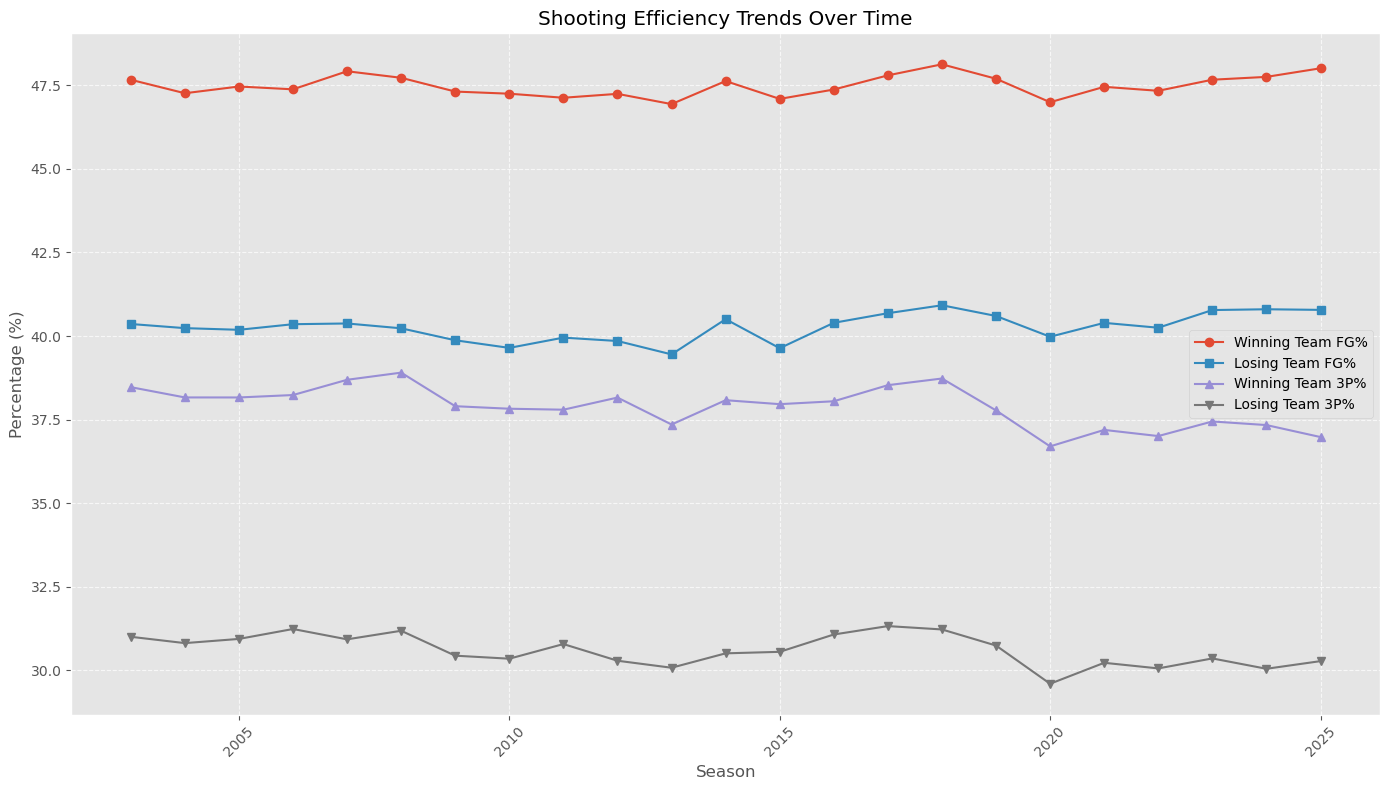

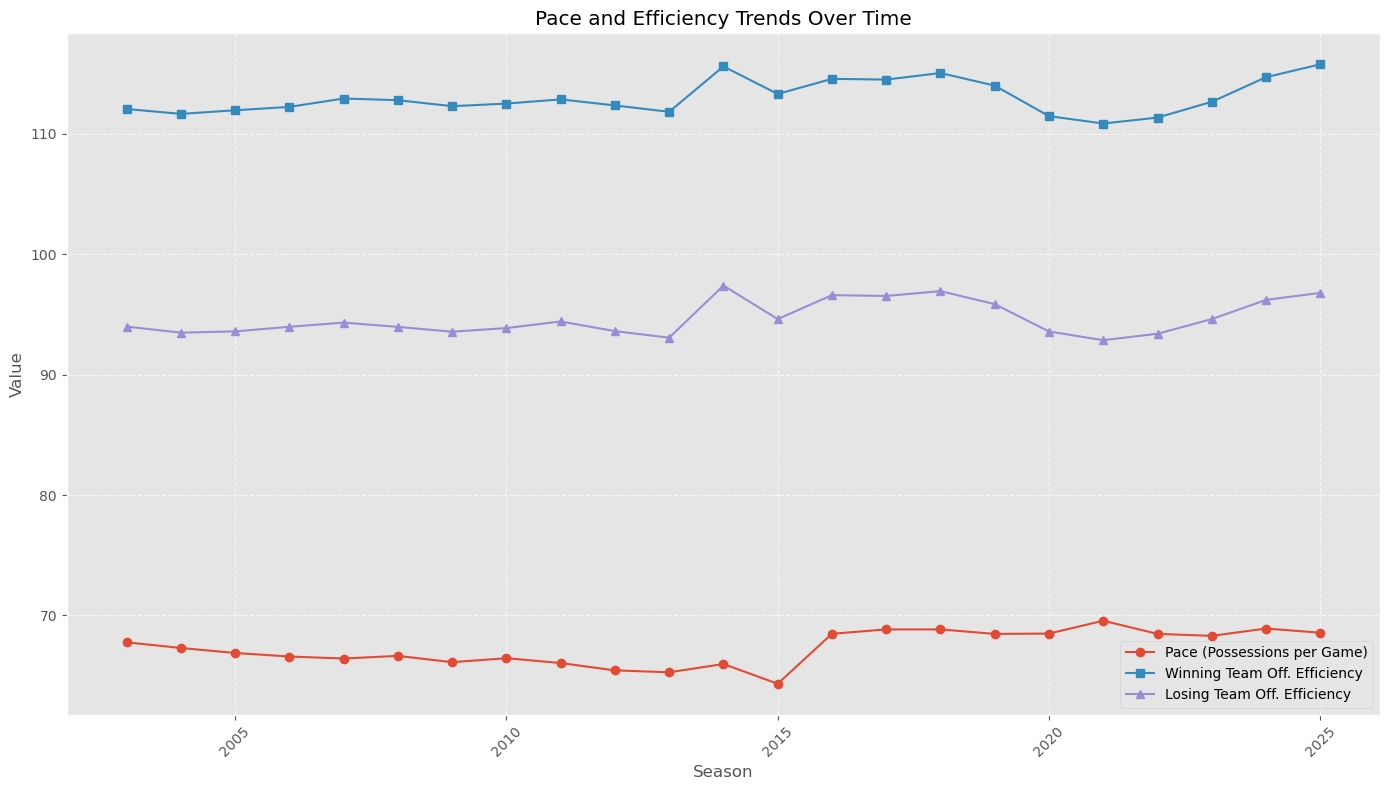

Analyzing correlations...
Visualizing correlations...


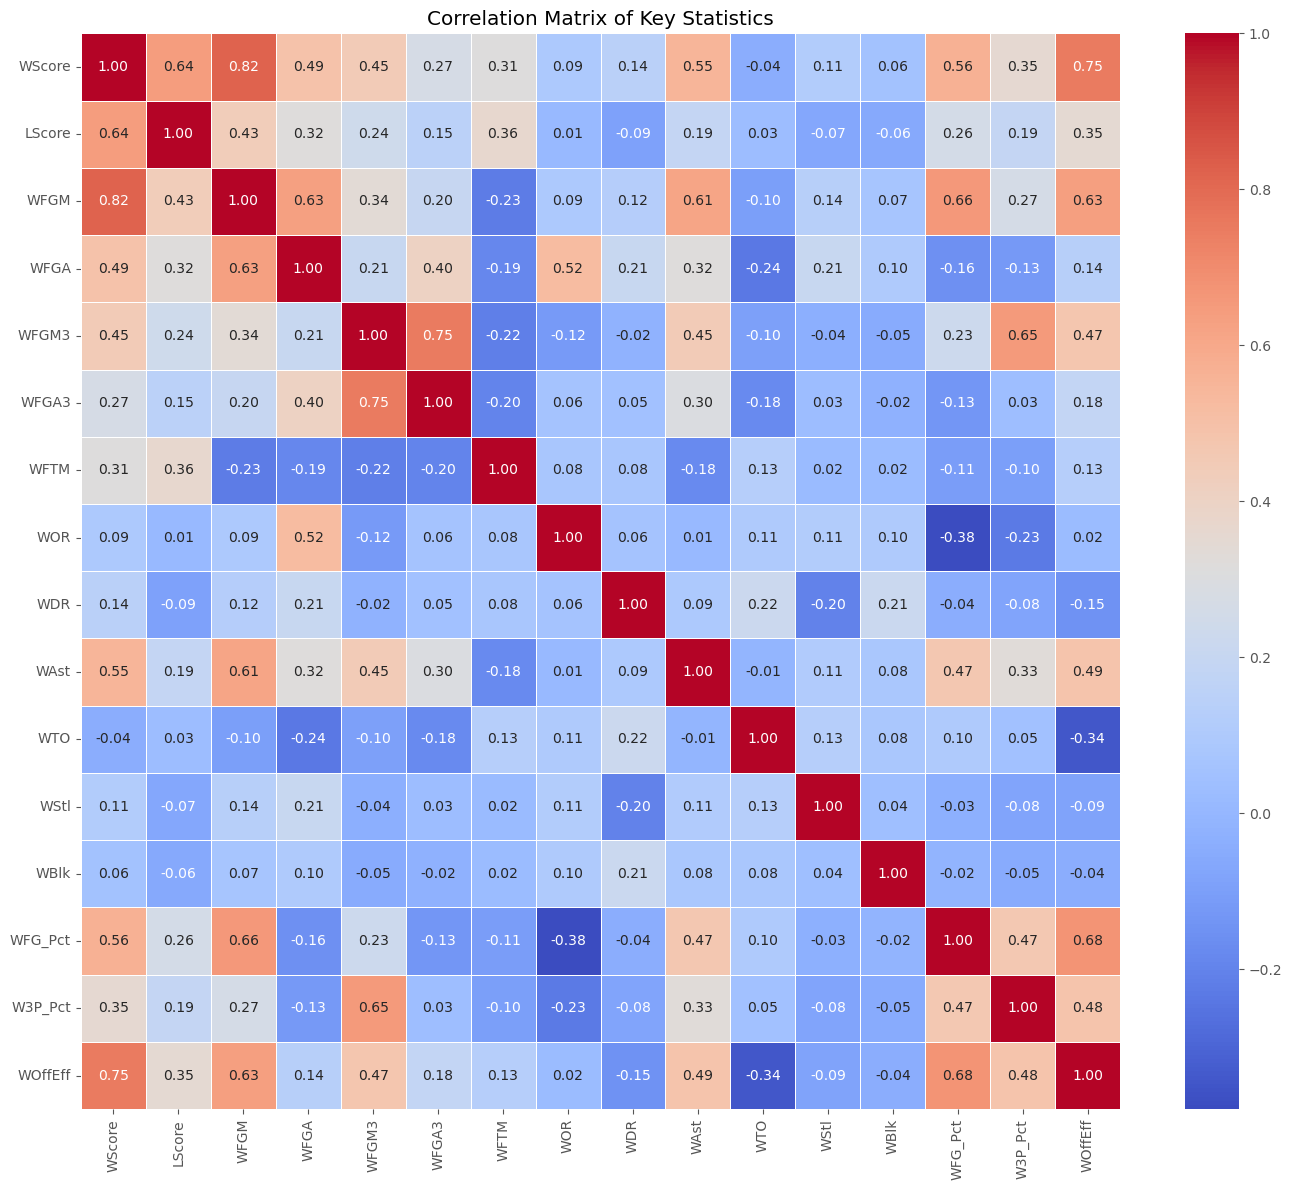

Building predictive model...

Model Accuracy: 0.9228

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     23745
           1       0.93      0.92      0.92     23907

    accuracy                           0.92     47652
   macro avg       0.92      0.92      0.92     47652
weighted avg       0.92      0.92      0.92     47652

Brier score: 0.0657
Visualizing feature importance...


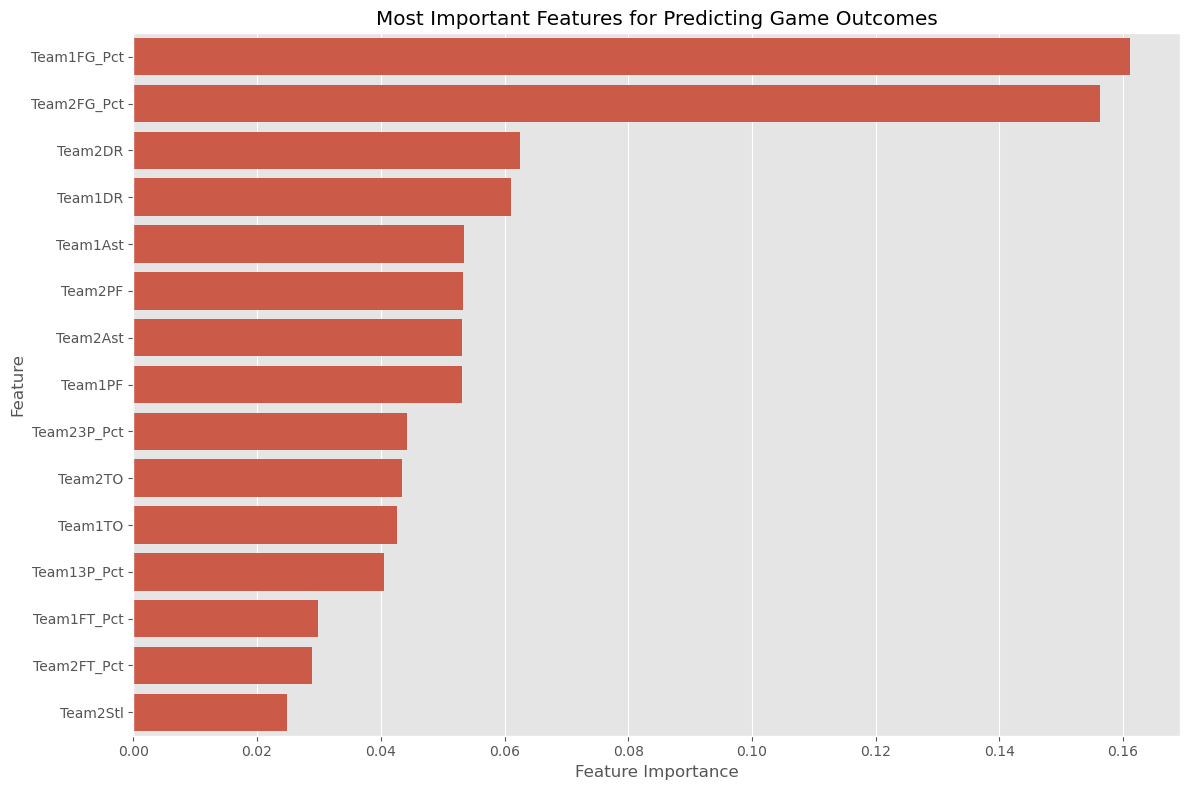

Comparing men's and women's basketball...

Gender Comparison:
              Men  Women  Difference  Pct_Difference
avg_score   70.31  64.51        5.80            9.00
fg_pct      43.88  40.04        3.84            9.59
3p_pct      34.09  31.07        3.02            9.72
ft_pct      70.11  69.55        0.56            0.80
rebounds    16.93  18.14       -1.21           -6.69
assists     12.93  12.96       -0.03           -0.21
steals       6.32   7.87       -1.55          -19.69
blocks       3.35   3.26        0.10            2.99
turnovers   12.67  16.08       -3.40          -21.17
fouls       18.03  17.11        0.91            5.33
efficiency 104.21  92.32       11.90           12.89
pace        67.49  69.88       -2.39           -3.42
Visualizing gender comparison...


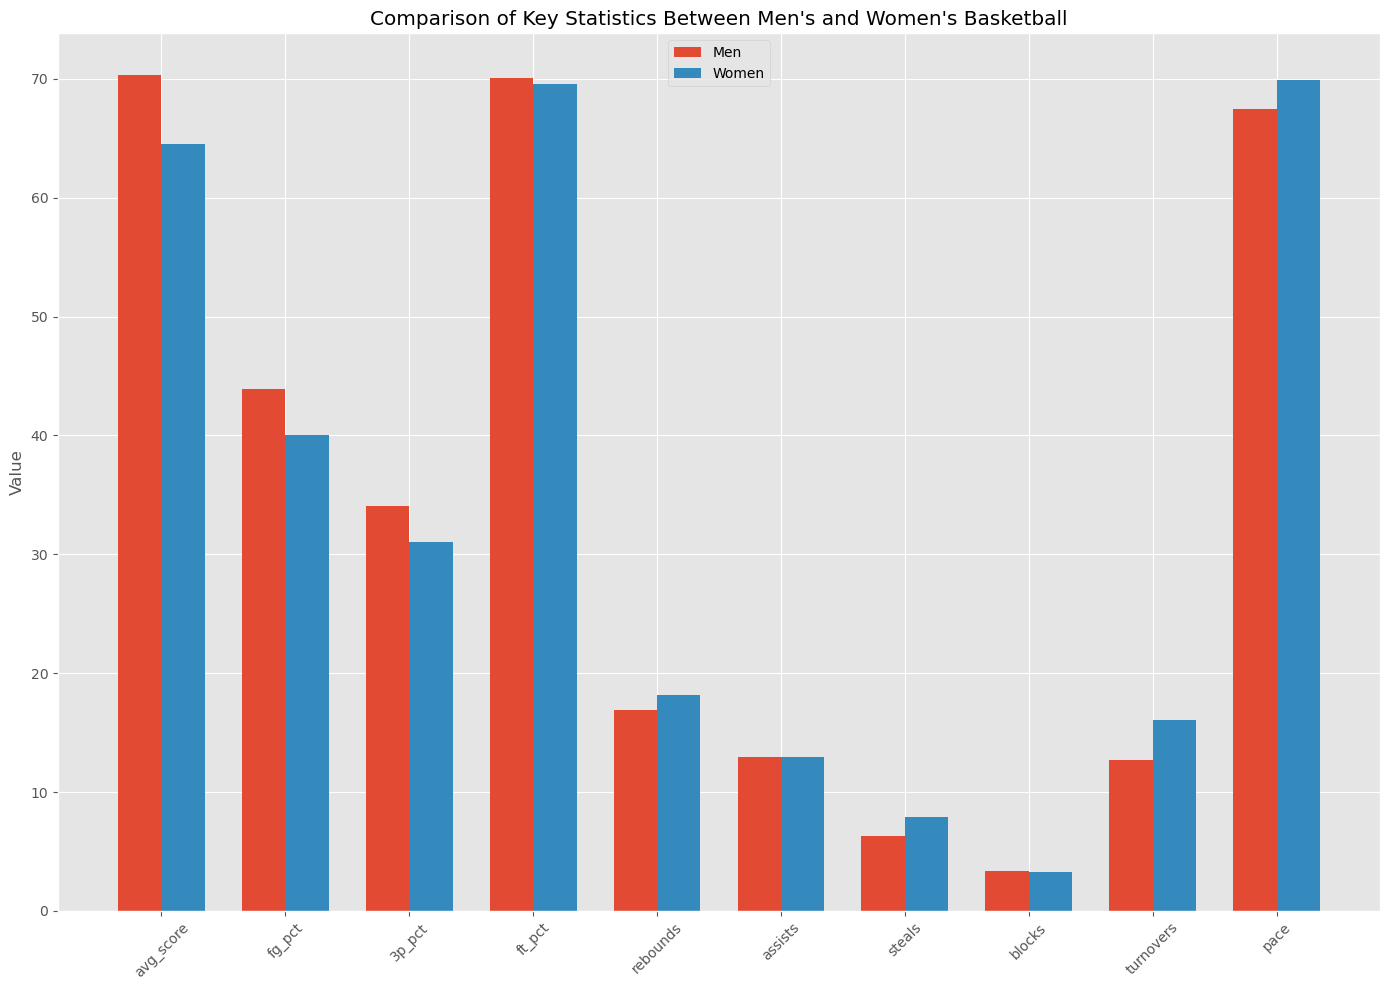

All analyses and visualizations completed!


In [159]:
men_regular_season_file = "data\MRegularSeasonDetailedResults.csv"
men_tournament_file = "data\MNCAATourneyDetailedResults.csv"
women_regular_season_file = "data\WRegularSeasonDetailedResults.csv"
women_tournament_file = "data\WNCAATourneyDetailedResults.csv"
    
# Combine data
print("Loading and combining men's basketball data...")
men_data = combine_data(men_regular_season_file, men_tournament_file)
    
print("Loading and combining women's basketball data...")
women_data = combine_data(women_regular_season_file, women_tournament_file)
    
# Analyze basic statistics
print("Analyzing basic statistics...")
men_stats_comparison = basic_stats_analysis(men_data)
print("\nMen's Basic Statistics Comparison:")
print(men_stats_comparison)
    
# Visualize basic statistics
print("Visualizing basic statistics...")
visualize_basic_stats(men_stats_comparison)
    
# Analyze efficiency
print("Analyzing efficiency...")
men_data, men_efficiency_stats = efficiency_analysis(men_data)
print("\nMen's Efficiency Statistics:")
print(men_efficiency_stats)
    
# Visualize efficiency
print("Visualizing efficiency...")
visualize_efficiency(men_efficiency_stats)
    
# Analyze time trends
print("Analyzing time trends...")
men_yearly_stats = time_trend_analysis(men_data)
print("\nMen's Yearly Statistics:")
print(men_yearly_stats.head())
    
# Visualize time trends
print("Visualizing time trends...")
visualize_time_trends(men_yearly_stats)
    
# Analyze correlations
print("Analyzing correlations...")
men_correlation_matrix = correlation_analysis(men_data)
    
# Visualize correlations
print("Visualizing correlations...")
visualize_correlation(men_correlation_matrix)
    
# Build predictive model
print("Building predictive model...")
accuracy, report, brier, feature_importance, rf_model, scaler, features = predictive_model(men_data)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

print(f"Brier score: {brier:.4f}")

# Visualize feature importance
print("Visualizing feature importance...")
visualize_feature_importance(feature_importance)
    
# Compare men's and women's basketball
print("Comparing men's and women's basketball...")
women_data, women_efficiency_stats = efficiency_analysis(women_data)
gender_comparison = compare_mens_womens(men_data, women_data)
print("\nGender Comparison:")
print(gender_comparison)
    
# Visualize gender comparison
print("Visualizing gender comparison...")
visualize_gender_comparison(gender_comparison)
    
print("All analyses and visualizations completed!")
    
# Display all plots
plt.show()

# Wszystko na dole do edycji!!

In [141]:
def create_team_stats_lookup(data):
    """
    Create a lookup dictionary for team season statistics.
    
    Parameters:
    data (DataFrame): Regular season results and team statistics
    
    Returns:
    dict: Nested dictionary with [season][team_id] -> stats
    """
    team_stats = {}
    
    # Process all games to collect statistics for each team
    for _, row in data.iterrows():
        season = row['Season']
        
        # Initialize season if not exists
        if season not in team_stats:
            team_stats[season] = {}
            
        # Process winning team
        w_team_id = row['WTeamID']
        if w_team_id not in team_stats[season]:
            team_stats[season][w_team_id] = {
                'games': 0,
                'wins': 0,
                'FGM': 0, 'FGA': 0,
                'FGM3': 0, 'FGA3': 0,
                'FTM': 0, 'FTA': 0,
                'OR': 0, 'DR': 0,
                'Ast': 0, 'TO': 0,
                'Stl': 0, 'Blk': 0,
                'PF': 0
            }
        
        # Update winning team stats
        team_stats[season][w_team_id]['games'] += 1
        team_stats[season][w_team_id]['wins'] += 1
        team_stats[season][w_team_id]['FGM'] += row['WFGM']
        team_stats[season][w_team_id]['FGA'] += row['WFGA']
        team_stats[season][w_team_id]['FGM3'] += row['WFGM3']
        team_stats[season][w_team_id]['FGA3'] += row['WFGA3']
        team_stats[season][w_team_id]['FTM'] += row['WFTM']
        team_stats[season][w_team_id]['FTA'] += row['WFTA']
        team_stats[season][w_team_id]['OR'] += row['WOR']
        team_stats[season][w_team_id]['DR'] += row['WDR']
        team_stats[season][w_team_id]['Ast'] += row['WAst']
        team_stats[season][w_team_id]['TO'] += row['WTO']
        team_stats[season][w_team_id]['Stl'] += row['WStl']
        team_stats[season][w_team_id]['Blk'] += row['WBlk']
        team_stats[season][w_team_id]['PF'] += row['WPF']
        
        # Process losing team
        l_team_id = row['LTeamID']
        if l_team_id not in team_stats[season]:
            team_stats[season][l_team_id] = {
                'games': 0,
                'wins': 0,
                'FGM': 0, 'FGA': 0,
                'FGM3': 0, 'FGA3': 0,
                'FTM': 0, 'FTA': 0,
                'OR': 0, 'DR': 0,
                'Ast': 0, 'TO': 0,
                'Stl': 0, 'Blk': 0,
                'PF': 0
            }
        
        # Update losing team stats
        team_stats[season][l_team_id]['games'] += 1
        team_stats[season][l_team_id]['FGM'] += row['LFGM']
        team_stats[season][l_team_id]['FGA'] += row['LFGA']
        team_stats[season][l_team_id]['FGM3'] += row['LFGM3']
        team_stats[season][l_team_id]['FGA3'] += row['LFGA3']
        team_stats[season][l_team_id]['FTM'] += row['LFTM']
        team_stats[season][l_team_id]['FTA'] += row['LFTA']
        team_stats[season][l_team_id]['OR'] += row['LOR']
        team_stats[season][l_team_id]['DR'] += row['LDR']
        team_stats[season][l_team_id]['Ast'] += row['LAst']
        team_stats[season][l_team_id]['TO'] += row['LTO']
        team_stats[season][l_team_id]['Stl'] += row['LStl']
        team_stats[season][l_team_id]['Blk'] += row['LBlk']
        team_stats[season][l_team_id]['PF'] += row['LPF']
    
    # Calculate averages and percentages for each team
    for season in team_stats:
        for team_id in team_stats[season]:
            games = team_stats[season][team_id]['games']
            
            # Guard against division by zero
            if games > 0:
                stats = team_stats[season][team_id]
                
                # Calculate per game averages
                for stat in ['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']:
                    stats[f'{stat}_pg'] = stats[stat] / games
                
                # Calculate percentages safely
                stats['FG_Pct'] = safe_div(stats['FGM'], stats['FGA']).round(2)
                stats['FG3_Pct'] = safe_div(stats['FGM3'], stats['FGA3']).round(2)
                stats['FT_Pct'] = safe_div(stats['FTM'], stats['FTA']).round(2)
                stats['Win_Pct'] = (stats['wins'] / games) * 100
    
    return team_stats


def get_team_stats(team_stats_lookup, season, team_id):
    """
    Get a team's statistics for a specific season.
    
    Parameters:
    team_stats_lookup (dict): Team statistics lookup dictionary
    season (int): Season year
    team_id (int): Team ID
    
    Returns:
    dict: Team statistics
    """
    # If we don't have stats for this team/season, return defaults
    if season not in team_stats_lookup or team_id not in team_stats_lookup[season]:
        return {
            'FG_Pct': 45.0,      # Default FG%
            'FG3_Pct': 33.0,     # Default 3P%
            'FT_Pct': 70.0,      # Default FT%
            'OR_pg': 10.0,       # Default offensive rebounds per game
            'DR_pg': 25.0,       # Default defensive rebounds per game
            'Ast_pg': 12.0,      # Default assists per game
            'TO_pg': 12.0,       # Default turnovers per game
            'Stl_pg': 7.0,       # Default steals per game
            'Blk_pg': 3.0,       # Default blocks per game
            'PF_pg': 18.0,       # Default fouls per game
            'Win_Pct': 50.0      # Default win percentage
        }
    
    # Return the actual stats
    stats = team_stats_lookup[season][team_id]
    return {
        'FG_Pct': stats['FG_Pct'],
        'FG3_Pct': stats['FG3_Pct'],
        'FT_Pct': stats['FT_Pct'],
        'OR_pg': stats['OR_pg'],
        'DR_pg': stats['DR_pg'],
        'Ast_pg': stats['Ast_pg'],
        'TO_pg': stats['TO_pg'],
        'Stl_pg': stats['Stl_pg'],
        'Blk_pg': stats['Blk_pg'],
        'PF_pg': stats['PF_pg'],
        'Win_Pct': stats['Win_Pct']
    }


def create_matchup_features(team1_stats, team2_stats):
    """
    Create feature vector for matchup between teams.
    
    Parameters:
    team1_stats (dict): Team 1 statistics (lower TeamID)
    team2_stats (dict): Team 2 statistics (higher TeamID)
    
    Returns:
    dict: Features for model prediction
    """
    return {
        'Team1FG_Pct': team1_stats['FG_Pct'],
        'Team13P_Pct': team1_stats['FG3_Pct'],
        'Team1FT_Pct': team1_stats['FT_Pct'],
        'Team1OR': team1_stats['OR_pg'],
        'Team1DR': team1_stats['DR_pg'],
        'Team1Ast': team1_stats['Ast_pg'],
        'Team1TO': team1_stats['TO_pg'],
        'Team1Stl': team1_stats['Stl_pg'],
        'Team1Blk': team1_stats['Blk_pg'],
        'Team1PF': team1_stats['PF_pg'],
        'Team2FG_Pct': team2_stats['FG_Pct'],
        'Team23P_Pct': team2_stats['FG3_Pct'],
        'Team2FT_Pct': team2_stats['FT_Pct'],
        'Team2OR': team2_stats['OR_pg'],
        'Team2DR': team2_stats['DR_pg'],
        'Team2Ast': team2_stats['Ast_pg'],
        'Team2TO': team2_stats['TO_pg'],
        'Team2Stl': team2_stats['Stl_pg'],
        'Team2Blk': team2_stats['Blk_pg'],
        'Team2PF': team2_stats['PF_pg']
    }




In [142]:
def generate_tournament_predictions(matchups_df, rf_model, scaler, features, team_stats_lookup):
    """
    Generate tournament matchup predictions.
    
    Parameters:
    matchups_df (DataFrame): Tournament matchups with ID column
    rf_model: Trained RandomForestClassifier model
    scaler: Fitted StandardScaler
    features (list): Feature names used by the model
    team_stats_lookup (dict): Team statistics lookup
    
    Returns:
    DataFrame: Predictions with ID and Pred columns
    """
    predictions = []
    
    for _, row in matchups_df.iterrows():
        matchup_id = row['ID']
        parts = matchup_id.split('_')
        
        try:
            season = int(parts[0])
            team1_id = int(parts[1])  # Lower TeamID
            team2_id = int(parts[2])  # Higher TeamID
            
            # Get team statistics
            team1_stats = get_team_stats(team_stats_lookup, season, team1_id)
            team2_stats = get_team_stats(team_stats_lookup, season, team2_id)
            
            # Create features for this matchup
            matchup_features = create_matchup_features(team1_stats, team2_stats)
            
            # Ensure features are in the right order
            features_vector = [matchup_features[feat] for feat in features]
            
            # Scale features using the same scaler as training
            scaled_features = scaler.transform([features_vector])
            
            # Predict probability that team1 (lower TeamID) beats team2 (higher TeamID)
            win_probability = rf_model.predict_proba(scaled_features)[0][1]
            
            predictions.append({
                'ID': matchup_id,
                'Pred': win_probability
            })
        except Exception as e:
            print(f"Error processing matchup {matchup_id}: {e}")
            # Fallback to 0.5 probability if anything goes wrong
            predictions.append({
                'ID': matchup_id,
                'Pred': 0.5
            })
    
    return pd.DataFrame(predictions)

In [ ]:
# 1. Load data
print("Loading data...")
regular_season_data = pd.read_csv('data/MRegularSeasonDetailedResults.csv')
submission_data = pd.read_csv('data/SampleSubmissionStage1.csv')
    
# 2. Create team statistics lookup
print("Creating team statistics lookup...")
team_stats_lookup = create_team_stats_lookup(regular_season_data)
    
# 3. Build predictive model
print("Building predictive model...")
accuracy, report, brier, feature_importance, rf_model, scaler, features = predictive_model(regular_season_data)
    
# 4. Print model evaluation
print(f"\nModel Accuracy: {accuracy:.4f}")
print(f"Brier Score: {brier:.6f}")
print("\nClassification Report:")
print(report)
print("\nFeature Importance:")
print(feature_importance)
    
# 5. Generate tournament predictions
print("\nGenerating tournament predictions...")
predictions = generate_tournament_predictions(submission_data, rf_model, scaler, features, team_stats_lookup)
    
# 6. Save predictions
predictions.to_csv('tournament_predictions.csv', index=False)
print(f"Predictions saved to tournament_predictions.csv")
    
predictions

Loading data...
Creating team statistics lookup...
Building predictive model...

Model Accuracy: 0.9187
Brier Score: 0.066664

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     23432
           1       0.92      0.91      0.92     23668

    accuracy                           0.92     47100
   macro avg       0.92      0.92      0.92     47100
weighted avg       0.92      0.92      0.92     47100


Feature Importance:
        Feature  Importance
0   Team1FG_Pct        0.16
10  Team2FG_Pct        0.15
14      Team2DR        0.06
4       Team1DR        0.06
5      Team1Ast        0.06
19      Team2PF        0.05
9       Team1PF        0.05
15     Team2Ast        0.05
11  Team23P_Pct        0.05
6       Team1TO        0.04
16      Team2TO        0.04
1   Team13P_Pct        0.04
12  Team2FT_Pct        0.03
2   Team1FT_Pct        0.03
7      Team1Stl        0.03
17     Team2Stl        0.02
13      Team2OR        0.0

D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Users\micha\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid f